# Предсказание количества заказов такси на следующий час

**Описание**:
В нашем распоряжении около 10 млн записей о поездках такси в Чикаго и перед нами стоит задача предсказать количество заказов на следующий час в каждом округе. Решать ее мы будем с применением PySpark на локальном кластере из Docker контейнеров

**Цель проекта**:
Построить ML модель на Spark предсказания количества заказов на следующий час для каждого района

**Описание данных**

**Данные о погоде в Чикаго**

 - *station* - станция наблюдения
 - *station_name* - имя станции
 - *valid(UTC)* - время наблюдения
 - *tmpf* - температура в F
 - *sknt* - скорость ветра
 - *vis1_coeff* - коэффициент видимости
 - *vis2_coeff* - коэффициент видимости
 - *vis3_coeff* - коэффициент видимости
 - *ptype* - код типа осадков
 - *precip* - количество осадковсто будет пустым для мест за пределами Чикаго.
еану.

 **Данные о населении в Чикаго**

 - *AREA* - код района
 - *COMMUNITY AREA* - название района
 - *square* - площадь района
 - *Population_thousand* - численность населения
 - *Total Households* - количество жилых домов
 - *White_people* - доля белого населения
 - *Black_people* - доля черного населения
 - *Latin_people* - доля латиноамериканского населения
 - *Other_people* - доля прочего населения
 - *Area_2* - макрозона

 **Данные о заказах такси в Чикаго**

 - *Trip ID* - Идентификатор поездки
 - *Taxi ID* - Идентификатор такси
 - *Trip Start Timestamp* - Время начала поездки округляется до ближайших 15 минут.
 - *Trip End Timestamp* - Когда поездка закончилась, округляется до ближайших 15 минут.
 - *Trip Seconds* - Время поездки в секундах.
 - *Trip Miles* - Расстояние поездки в милях.
 - *Pickup Census Tract* - Переписной тракт, где началась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок. Этот столбец часто будет пустым для мест за пределами Чикаго.
 - *Dropoff Census Tract* - Переписной тракт, где закончилась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок. Этот столбец часто будет пустым для мест за пределами Чикаго.
 - *Pickup Community Area* - Общественная зона, где началось путешествие. Этот столбец будет пустым для местоположений за пределами Чикаго.
 - *Dropoff Community Area* - Общественная зона, где закончилась поездка. Этот столбец будет пустым для местоположений за пределами Чикаго.
 - *Fare* - Стоимость проезда.
 - *Tips* - Совет для поездки. Денежные чаевые обычно не записываются.
 - *Tolls* - Стоимость проезда.
 - *Extras* - Дополнительные расходы на поездку.
 - *Trip Total* - Общая стоимость поездки, сумма предыдущих столбцов.
 - *Payment Type* - Вид оплаты за поездку.
 - *Company* - Компания такси.
 - *Pickup Centroid Latitude* - Широта центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
 - *Pickup Centroid Longitude* - Долгота центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
 - *Pickup Centroid Location* - Местоположение центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
 - *Dropoff Centroid Latitude* - Широта центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
 - *Dropoff Centroid Longitude* - Долгота центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго
 - *Dropoff Centroid Location* - Местоположение центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.


In [ ]:
pip install holidays -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install folium -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import types

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from multiprocessing.pool import ThreadPool
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, LinearRegressionTrainingSummary, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import datetime
import holidays
import folium
from folium.plugins import MarkerCluster

In [ ]:
SPARK_MASTER_IP = '172.18.0.2'

spark = SparkSession.builder.appName('pyspark-taxi-forecasting')\
                    .master(f'spark://{SPARK_MASTER_IP}:7077')\
                    .config('spark.executor.cores', 1)\
                    .config('spark.driver.memory', '25g')\
                    .config('spark.task.cpus', 1)\
                    .getOrCreate()

## 1. Загрузка данных и предварительная обработка

Объеденим датасеты за 2022 и 2023 год. В данных присуствует много полезной информации, но для наших целей пока будет достаточно взять лишь 5 признаков:
 - нужен обязательно регион начала поездки
 - время старта поездки
 - время поездки в секундах
 - количество миль
 - суммарная стоимость заказа

Район назначения полезен будет для анализа, но в качестве признака он не применим, т.к. мы не можем заранее угадать, куда клиент закажет такси. Это возможно лишь в том случае, если у нас есть история его поездок. Это касается и остальных признаков.

In [ ]:
data_2022 = spark.read.load('2022.csv', format = 'csv', inferSchema = True, header = 'true')
data_2023 = spark.read.load('2023.csv', format = 'csv', inferSchema = True, header = 'true')
df_all = data_2022.union(data_2023)

df = df_all.select(['Trip Start Timestamp','Trip Seconds','Trip Miles','Pickup Community Area','Trip Total'])

df.printSchema()
print('Size dataframe:', (df.count(), len(df.columns)))
df.show(2)

root
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Trip Total: double (nullable = true)

Size dataframe: (10166155, 5)
+--------------------+------------+----------+---------------------+----------+
|Trip Start Timestamp|Trip Seconds|Trip Miles|Pickup Community Area|Trip Total|
+--------------------+------------+----------+---------------------+----------+
|01/01/2022 12:00:...|         152|       0.1|                 null|      3.75|
|01/01/2022 12:00:...|        2360|     17.44|                 null|     52.75|
+--------------------+------------+----------+---------------------+----------+
only showing top 2 rows



Поработаем немного с датой. По заданию требуется предсказать количество заказов на следующий час, поэтому в дальнейшем мы будем группировать данные по часам. Отформатируем дату так, чтобы в ней осталась информация вида день-месяц-год-час. Дополнительно получим отдельные признаки: год, месяц, день месяца, день недели. Не факт, что в дальнейшем они пригодятся в качестве фичей, но для аналитики будут очень полезны.
Из описания данных ясно, что пропуски в столбце с районом начала поездки означают поездку за город. Заменим пропуски на 0.

In [ ]:
func_replace_nan = F.when((F.isnull('Pickup Community Area'))|(F.isnan('Pickup Community Area')), 0).otherwise(F.col('Pickup Community Area'))

df = df.withColumn('Trip Start Timestamp', F.to_timestamp(F.col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a')) \
       .withColumn('Date_H', F.date_format('Trip Start Timestamp', 'MM.dd.yyyy HH'))\
       .withColumn('Date', F.date_format('Trip Start Timestamp', 'yyyy-MM-dd'))\
       .withColumn('year', F.year('Trip Start Timestamp')) \
       .withColumn('month', F.month('Trip Start Timestamp')) \
       .withColumn('day', F.dayofmonth('Trip Start Timestamp')) \
       .withColumn('weekday', F.dayofweek('Trip Start Timestamp'))\
       .withColumn('hour', F.hour('Trip Start Timestamp'))\
       .withColumn('Pickup_Community_Area', func_replace_nan)


Теперь подгрузим данные о погоде за каждый час в Чикаго. Сделаем допущение, что погода за городом Чикаго аналогичная. Здесь нам пригодится:
 - Средняя температура по ощущениям (либо индекс прохлады ветром, либо индекс жары).
 - Скорость ветра
 - Коэффициент видимости
 - Код типа осадков
 - Количество осадков за минуту

In [ ]:
weather = spark.read.load('changeme.csv', format = 'csv', inferSchema = True, header = 'true')
weather.printSchema()

weather = weather.withColumn('Date_H', F.date_format('valid(UTC)', 'dd.MM.yyyy HH'))\
                 .select(['Date_H', 'tmpf','sknt','vis1_coeff','ptype','precip'])
weather.show(5)

root
 |-- station: string (nullable = true)
 |-- station_name: string (nullable = true)
 |-- valid(UTC): timestamp (nullable = true)
 |-- tmpf: integer (nullable = true)
 |-- sknt: integer (nullable = true)
 |-- vis1_coeff: double (nullable = true)
 |-- vis2_coeff: double (nullable = true)
 |-- vis3_coeff: string (nullable = true)
 |-- ptype: string (nullable = true)
 |-- precip: double (nullable = true)
 |-- _c10: string (nullable = true)

+-------------+----+----+----------+-----+------+
|       Date_H|tmpf|sknt|vis1_coeff|ptype|precip|
+-------------+----+----+----------+-----+------+
|01.01.2022 06|  41|  13|     0.251|   NP|   0.0|
|01.01.2022 07|  41|  14|     0.361|   NP|   0.0|
|01.01.2022 08|  40|  10|     0.522|   NP|   0.0|
|01.01.2022 09|  40|  13|     0.181|   NP|   0.0|
|01.01.2022 10|  40|  12|     0.102|   NP|   0.0|
+-------------+----+----+----------+-----+------+
only showing top 5 rows



In [ ]:
all_dates = df.select(['Date_H', 'Date', 'year', 'month', 'day', 'weekday', 'hour']).distinct()\
              .join(weather, how = 'left', on = 'Date_H')\
              .orderBy('Date_H').fillna({'ptype':'unknown', 'precip':0.0})
all_dates.show(10)

+-------------+----------+----+-----+---+-------+----+----+----+----------+-------+------+
|       Date_H|      Date|year|month|day|weekday|hour|tmpf|sknt|vis1_coeff|  ptype|precip|
+-------------+----------+----+-----+---+-------+----+----+----+----------+-------+------+
|01.01.2022 00|2022-01-01|2022|    1|  1|      7|   0|null|null|      null|unknown|   0.0|
|01.01.2022 01|2022-01-01|2022|    1|  1|      7|   1|null|null|      null|unknown|   0.0|
|01.01.2022 02|2022-01-01|2022|    1|  1|      7|   2|null|null|      null|unknown|   0.0|
|01.01.2022 03|2022-01-01|2022|    1|  1|      7|   3|null|null|      null|unknown|   0.0|
|01.01.2022 04|2022-01-01|2022|    1|  1|      7|   4|null|null|      null|unknown|   0.0|
|01.01.2022 05|2022-01-01|2022|    1|  1|      7|   5|null|null|      null|unknown|   0.0|
|01.01.2022 06|2022-01-01|2022|    1|  1|      7|   6|  41|  13|     0.251|     NP|   0.0|
|01.01.2022 07|2022-01-01|2022|    1|  1|      7|   7|  41|  14|     0.361|     NP|   0.0|

Посчитаем пропуски в данных о погоде.

In [ ]:
#подсчет значений с пропусками
def count_na_null (df):
    print('Наличие пропусков в датасете')
    for column in df.columns:
        print(column, df.filter((F.col(column).isNull())|(F.isnan(column))).count())

In [ ]:
count_na_null(all_dates)

Наличие пропусков в датасете
Date_H 0
Date 0
year 0
month 0
day 0
weekday 0
hour 0
tmpf 9306
sknt 9345
vis1_coeff 9324
ptype 0
precip 0


Итак, у нас есть пропуски в данных о температуре, влажности и скорости ветра. Предполагаю, что самым корректным способом борьбы с пропусками было бы использование данных о погоде по соседним часам этого же дня, но проблема осложняется тем, что есть ряд дат, в которых отсуствуют данные за весь день. Поэтому пока заменим пропуски медианными значениями за текущий месяц.

In [ ]:
median_values = all_dates.groupBy(['year', 'month'])\
                         .agg(F.median('tmpf'), F.median('sknt'), F.median('vis1_coeff'))
all_dates = all_dates.join(median_values, how = 'left', on = ['year', 'month'])

In [ ]:
%%time
columns = ['tmpf', 'sknt', 'vis1_coeff']
for col in columns:
    col_median_names = f'median({col})'
    func_replace_null = F.when((F.col(col).isNull()), F.col(col_median_names)*1).otherwise(F.col(col))
    all_dates = all_dates.withColumn(f'{col}_new', func_replace_null)

all_dates.filter(F.col('tmpf').isNull()).select(['tmpf', 'median(tmpf)', 'tmpf_new']).show(5)

+----+------------+--------+
|tmpf|median(tmpf)|tmpf_new|
+----+------------+--------+
|null|        54.0|    54.0|
|null|        54.0|    54.0|
|null|        54.0|    54.0|
|null|        54.0|    54.0|
|null|        54.0|    54.0|
+----+------------+--------+
only showing top 5 rows

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 20.3 s


In [ ]:
all_dates = all_dates.select(['Date_H','Date','year','month','day',
                              'weekday','hour','tmpf_new','sknt_new','vis1_coeff_new', 'ptype','precip'])
count_na_null(all_dates)

Наличие пропусков в датасете
Date_H 0
Date 0
year 0
month 0
day 0
weekday 0
hour 0
tmpf_new 0
sknt_new 0
vis1_coeff_new 0
ptype 0
precip 0


Первично оценим данные на наличие экстримальных значений.

In [ ]:
df_all_interval_month = df.groupBy(['Date','year', 'month']).agg(F.count('Trip Start Timestamp')\
                                                            .alias('count_trip_period')).orderBy(['Date']).toPandas()
df_all_interval_month.head(5)

,Date,year,month,count_trip_period
0,2022-01-01,2022,1,7939
1,2022-01-02,2022,1,9031
2,2022-01-03,2022,1,11214
3,2022-01-04,2022,1,10440
4,2022-01-05,2022,1,10124


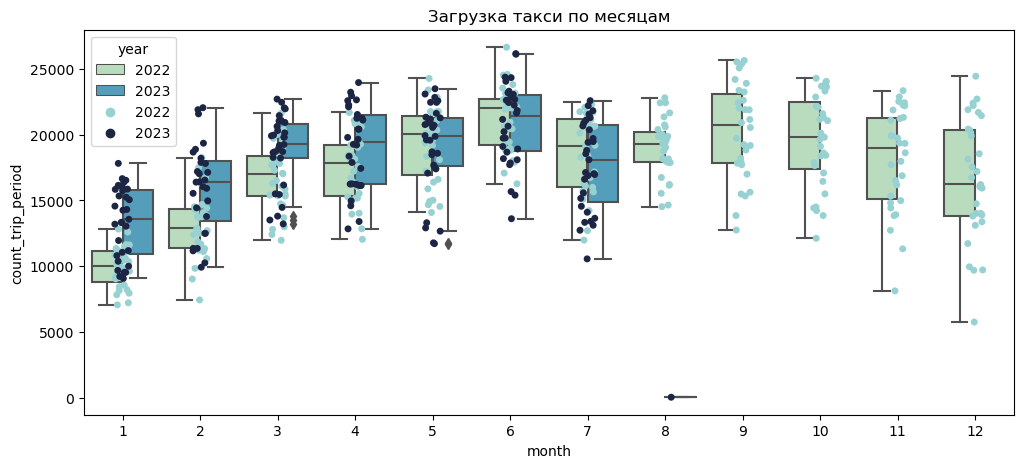

In [ ]:
plt.figure(figsize=(12, 5))

plt.title('Загрузка такси по месяцам')
sns.boxplot(df_all_interval_month, palette='GnBu',
             x = 'month', y = 'count_trip_period', hue='year')
sns.stripplot(df_all_interval_month, palette='ch:rot=-.25,hue=1,light=.75',
             x = df_all_interval_month.month, y = df_all_interval_month.count_trip_period, hue = 'year')
plt.show()

В августе 2023 года есть немного данных за первые дни. Исключим этот месяц из выборки по заказам и погодных данных.

In [ ]:
df = df.filter(F.col('Trip Start Timestamp')<'2023-08-01 00:00:00')
print('Size base dataframe:', (df.count(), len(df.columns)))

print('Size all_dates before:', (all_dates.count(), len(all_dates.columns)))
all_dates = all_dates.filter((F.col('year')!=2023)|(F.col('month')!=8))
print('Size all_dates after:', (all_dates.count(), len(all_dates.columns)))

Size base dataframe: (10166125, 13)
Size all_dates before: (13847, 12)
Size all_dates after: (13846, 12)


Теперь посмотрим на пропуски по данным о поездках. Нас интересуют данные о времени, стоимости и дальности поездки.

In [ ]:
count_na_null(df.select(['Trip Seconds','Trip Miles','Trip Total']))

Наличие пропусков в датасете
Trip Seconds 2183
Trip Miles 69
Trip Total 8939


Получим медианные значения количества миль в секунду и цены за милю. Используем их в замене пропусков:
 - пропуски по времени поездки заменим на количество миль/медианное значение количества миль в секунду
 - пропуски по дальности заменим на количество секунд*медианное значение количества миль в секунду
 - пропуски по стоимости заменим на количество миль*медианное значение цены за милю

In [ ]:
median_miles_time = df.filter((~F.col('Trip Seconds').isNull())|(~F.col('Trip Miles').isNull()))\
                         .withColumn('avg_miles_time',  F.col('Trip Miles')/F.col('Trip Seconds'))\
                         .approxQuantile('avg_miles_time', [0.5], 0.25)[0]

median_price_miles = df.filter((~F.col('Trip Miles').isNull())|(~F.col('Trip Total').isNull()))\
                         .withColumn('avg_price_miles',  F.col('Trip Total')/F.col('Trip Miles'))\
                         .approxQuantile('avg_price_miles', [0.5], 0.25)[0]

print(f'Для одной мили медианное время - {median_miles_time}, медианная цена - {median_price_miles}')

func_null_seconds = (
    F.when((F.isnull('Trip Seconds'))|(F.isnan('Trip Seconds')), F.col('Trip Miles')/median_miles_time)
     .otherwise(F.col('Trip Seconds'))
)
func_null_miles = (
    F.when((F.isnull('Trip Miles'))|(F.isnan('Trip Miles')), F.col('Trip Seconds')*median_miles_time)
     .otherwise(F.col('Trip Miles'))
)
func_null_total = (
    F.when((F.isnull('Trip Total'))|(F.isnan('Trip Total')), F.col('Trip Miles')*median_price_miles)
     .otherwise(F.col('Trip Total'))
)
df = df.withColumn('Trip_Seconds', func_null_seconds)\
       .withColumn('Trip_Miles', func_null_miles)\
       .withColumn('Trip_Total', func_null_total)\
       .withColumn('trip_time_minutes', F.round(F.col('Trip_Seconds').cast('int')/60,2))

Для одной мили медианное время - 0.0035714285714285713, медианная цена - 4.23728813559322


Проверим еще раз пропуски. Необработанными осталось две записи в которых отсуствует время и мили, при этом у одной поездки неадекватно высокая стоимость, а другая - нулевая.

In [ ]:
count_na_null(df.select(['Trip_Seconds','Trip_Miles','Trip_Total', 'trip_time_minutes']))

Наличие пропусков в датасете
Trip_Seconds 2
Trip_Miles 2
Trip_Total 1
trip_time_minutes 2


In [ ]:
df.filter(F.col('Trip_Seconds').isNull()).select(['Trip Start Timestamp','Trip_Seconds','Trip_Miles','Trip_Total']).show()
df = df.fillna({'Trip_Seconds':0.0, 'Trip_Miles':0.0, 'Trip_Total':0.0, 'trip_time_minutes':0.0})

+--------------------+------------+----------+----------+
|Trip Start Timestamp|Trip_Seconds|Trip_Miles|Trip_Total|
+--------------------+------------+----------+----------+
| 2022-08-10 20:15:00|        null|      null|       0.0|
| 2023-03-03 06:45:00|        null|      null|   9999.75|
+--------------------+------------+----------+----------+



А есть ли у нас еще такие поездки, сумма которых неоправдана? Посмотрим на средние цены поездки.
По милям смотреть не будем, так как там могут быть большие суммы за ожидание, при небольших расстояниях.

In [ ]:
df_all_interval_month = df.groupBy(['Date_H']).agg(F.mean('trip_time_minutes').alias('avg_time_minutes'),\
                                                   F.mean('Trip_Total').alias('avg_Trip_Total')).orderBy(['Date_H'])\
                          .toPandas()
df_all_interval_month.head(2)

,Date_H,avg_time_minutes,avg_Trip_Total
0,01.01.2022 00,14.223472,19.416397
1,01.01.2022 01,13.813576,20.849570


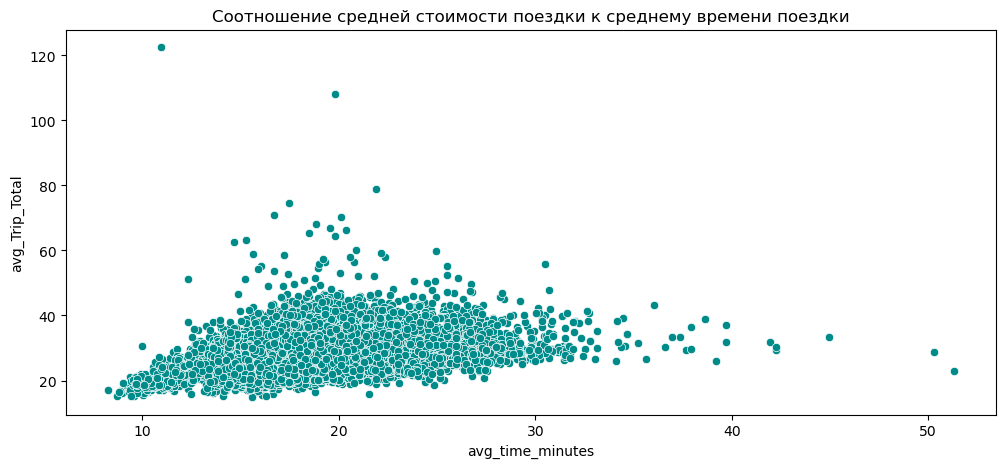

In [ ]:
plt.figure(figsize=(12, 5))
plt.title(f'Соотношение средней стоимости поездки к среднему времени поездки')
sns.scatterplot(df_all_interval_month, x = 'avg_time_minutes', y = 'avg_Trip_Total', color = 'darkcyan')
plt.show()

У нас есть данные о поездках с высокой ценой за малое время поездки. Здесь остается открытым вопрос, а время ожидания в поездке входит в общее время, или оно не учитывается? Есть еще длительные поездки за небольшую стоимость.

In [ ]:
df = df.withColumn('check_total_summ', (F.col('Trip_Total')/F.col('Trip_Miles')*median_price_miles)-1)
df.filter((F.col('Trip_Total')>1000)&(F.col('trip_time_minutes')<10)).select(['Trip Start Timestamp','Trip_Seconds','Trip_Miles','Trip_Total']).count()

273

Предположим, что время ожидания не учитывается в общем времени поездки, но влияет на стоимость. Или это хорошие чаевые водителю. Но поездки со стоимостью свыше 1000 долларов за время менее 10 минут лучше удалить как выбросы.

In [ ]:
df = df.filter((F.col('Trip_Total')<1000)|(F.col('trip_time_minutes')>10))
df.count()

10165842

У нас еще есть данные о населении в разрезе районов Чикаго и группировка их по центрам (для удобства назовем их макро-зонами или округами). Загрузим эти данные.

In [ ]:
data_trip= df.groupBy(['Date_H', 'Pickup_Community_Area']).agg(F.count('Date_H').cast('int').alias('Count_Trip'),\
                                                               F.sum('trip_time_minutes').alias('Sum_Trip_Minute'),\
                                                               F.sum('Trip_Miles').alias('Sum_Trip_Miles'),\
                                                               F.sum('Trip_Total').alias('Sum_Trip_Cost')).orderBy(['Pickup_Community_Area', 'Date_H'])
print(data_trip.count())
data_trip.show(5)

619881
+-------------+---------------------+----------+------------------+------------------+-----------------+
|       Date_H|Pickup_Community_Area|Count_Trip|   Sum_Trip_Minute|    Sum_Trip_Miles|    Sum_Trip_Cost|
+-------------+---------------------+----------+------------------+------------------+-----------------+
|01.01.2022 00|                    0|        17|            300.33|103.82000000000001|            445.9|
|01.01.2022 01|                    0|        34| 559.4599999999999|220.05000000000007|           1204.5|
|01.01.2022 02|                    0|        29|1190.1799999999996|259.80999999999995|          1079.82|
|01.01.2022 03|                    0|        21|278.59999999999997|            129.79|868.0899999999999|
|01.01.2022 04|                    0|        10|            205.83| 92.79999999999998|           343.21|
+-------------+---------------------+----------+------------------+------------------+-----------------+
only showing top 5 rows



Нам потребуются:
 - площадь района
 - население района
 - количество жилых домов в районе
 - доли белого, черного, латиноамериканского и прочего населения

In [ ]:
population = spark.read.load('population.csv', format = 'csv', inferSchema = True, header = 'true', sep=';')
population.printSchema()
population = population.select('AREA','square','Population_thousand','Total Households','White_people','Black_people',
                               'Latin_people','Other_people', 'Area_2').withColumnRenamed('AREA', 'Pickup_Community_Area')
population.show(5)

root
 |-- AREA: integer (nullable = true)
 |-- COMMUNITY AREA: string (nullable = true)
 |-- square: double (nullable = true)
 |-- Population_thousand: double (nullable = true)
 |-- Total Households: double (nullable = true)
 |-- White_people: double (nullable = true)
 |-- Black_people: double (nullable = true)
 |-- Latin_people: double (nullable = true)
 |-- Other_people: double (nullable = true)
 |-- Area_2: string (nullable = true)

+---------------------+------+-------------------+----------------+------------+------------+------------+------------+--------------+
|Pickup_Community_Area|square|Population_thousand|Total Households|White_people|Black_people|Latin_people|Other_people|        Area_2|
+---------------------+------+-------------------+----------------+------------+------------+------------+------------+--------------+
|                    1|  4.79|             55.628|         26402.0|        0.44|       0.268|       0.199|       0.093|Far North Side|
|                   

## 2. Исследовательский анализ данных

Объеденим все датасеты. Пропуски заполним нулями.

In [ ]:
data = all_dates.join(population)\
                .join(data_trip, on = ['Date_H', 'Pickup_Community_Area'], how = 'left')\
                .fillna(0)

Проанализируем наши данные.  Для этого сгруппируем наш датафрейм следующим образом: сначала по району, затем по макрозоне, году, месяцу, дню недели (это затем, чтобы быстрее строились графики. Если брать по дню месяца считаться будет дольше), часу и населению.
Добавим дополнительные колонки:
 - средний чек за поездку
 - средний чек за минуту
 - средний чек за милю
 - среднее количество миль за поездку

In [ ]:
df_all_interval_weekdays = data.groupBy(['Pickup_Community_Area', 'Area_2','year', 'month', 'weekday', 'hour',
                                        'Population_thousand','Total Households','White_people','Black_people','Latin_people','Other_people'])\
                               .agg(F.sum('Count_Trip').alias(('count_trip_period')),\
                                    F.mean('Count_Trip').alias(('count_mean_trip')),\
                                    F.sum('Sum_Trip_Minute').alias(('sum_trip_time')),\
                                    F.sum('Sum_Trip_Miles').alias('sum_total_miles'), F.sum('Sum_Trip_Cost').alias('sum_total_trip'))\
                               .withColumn('avg_price_trip', F.col('sum_total_trip')/F.col('count_trip_period'))\
                               .withColumn('avg_price_minute', F.col('sum_total_trip')/F.col('sum_trip_time'))\
                               .withColumn('avg_price_mile', F.col('sum_total_trip')/F.col('sum_total_miles'))\
                               .withColumn('avg_miles_trip', F.col('sum_total_miles')/F.col('count_trip_period')).toPandas()
df_all_interval_weekdays.head(5)

,Pickup_Community_Area,Area_2,year,month,weekday,hour,Population_thousand,Total Households,White_people,Black_people,...,Other_people,count_trip_period,count_mean_trip,sum_trip_time,sum_total_miles,sum_total_trip,avg_price_trip,avg_price_minute,avg_price_mile,avg_miles_trip
0,63,Southwest Side,2022,1,7,18,39.540,10353.0,0.038,0.044,...,0.009,2,0.4,52.00,0.60,50.00,25.000000,0.961538,83.333333,0.300000
1,67,Southwest Side,2022,1,1,3,29.647,9971.0,0.013,0.842,...,0.021,0,0.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN
2,77,Far North Side,2022,1,1,11,56.296,30466.0,0.543,0.126,...,0.171,57,11.4,1013.56,252.73,1082.54,18.991930,1.068057,4.283385,4.433860
3,16,Northwest Side,2022,1,1,15,51.940,21342.0,0.454,0.031,...,0.115,12,2.4,173.13,51.98,218.57,18.214167,1.262462,4.204886,4.331667
4,47,Far Southeast Side,2022,1,1,16,2.527,1036.0,0.016,0.901,...,0.031,1,0.2,25.98,7.27,24.00,24.000000,0.923788,3.301238,7.270000


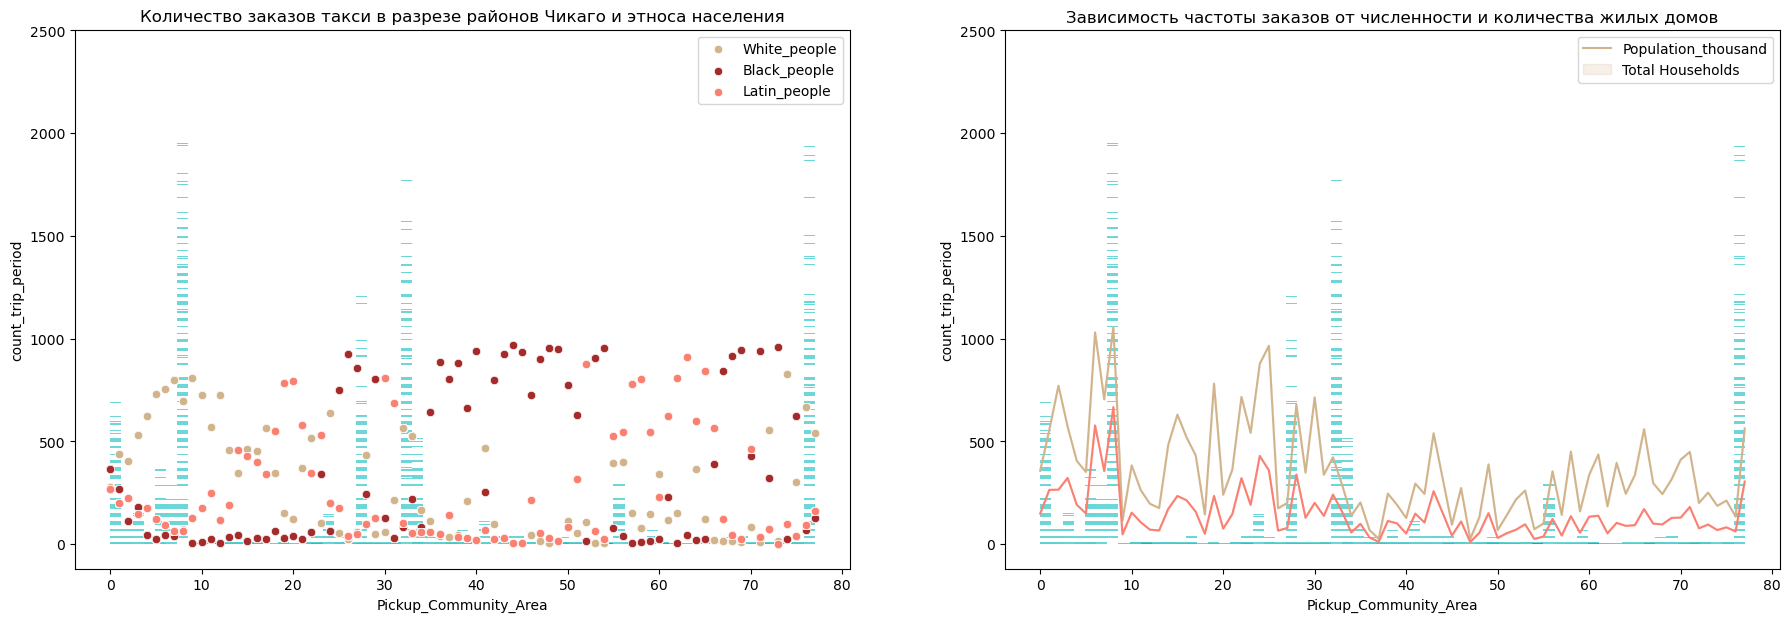

In [ ]:
plt.figure(figsize=(22, 7))

plt.subplot(1, 2, 1)
plt.title('Количество заказов такси в разрезе районов Чикаго и этноса населения')
sns.histplot(df_all_interval_weekdays, x = 'Pickup_Community_Area', y = 'count_trip_period', color = 'teal')
sns.scatterplot(df_all_interval_weekdays, x = 'Pickup_Community_Area', y = df_all_interval_weekdays['White_people']*1000, color = 'tan')
sns.scatterplot(df_all_interval_weekdays, x = 'Pickup_Community_Area', y = df_all_interval_weekdays['Black_people']*1000, color = 'brown')
sns.scatterplot(df_all_interval_weekdays, x = 'Pickup_Community_Area', y = df_all_interval_weekdays['Latin_people']*1000, color = 'salmon')
plt.legend(['White_people', 'Black_people', 'Latin_people'], loc = 0)

plt.subplot(1, 2, 2)
plt.title('Зависимость частоты заказов от численности и количества жилых домов')
sns.histplot(df_all_interval_weekdays, x = 'Pickup_Community_Area', y = 'count_trip_period', color = 'teal')
sns.lineplot(df_all_interval_weekdays, x = 'Pickup_Community_Area', y = df_all_interval_weekdays['Population_thousand']*10, color = 'tan')
sns.lineplot(df_all_interval_weekdays, x = 'Pickup_Community_Area', y = df_all_interval_weekdays['Total Households']/100, color = 'salmon')
plt.legend(['Population_thousand','Total Households'])

plt.show()

Итак, в тех районах, где живет бОльший процент белого населения, такси заказывают чаще. Но это правило, как видно на графике, применимо не ко всем районам. А вот зависимость между численностью населения и заказами тоже есть, но она не очевидна для многих районов. Что здесь могло бы пригодится? Наверное, количество проживающих в районе белых людей, или их соотношению к числу заказов такси в районе. Мы обратимся к этой гипотезе дальше. Районы с 9 по 27 возможно являются спальными.

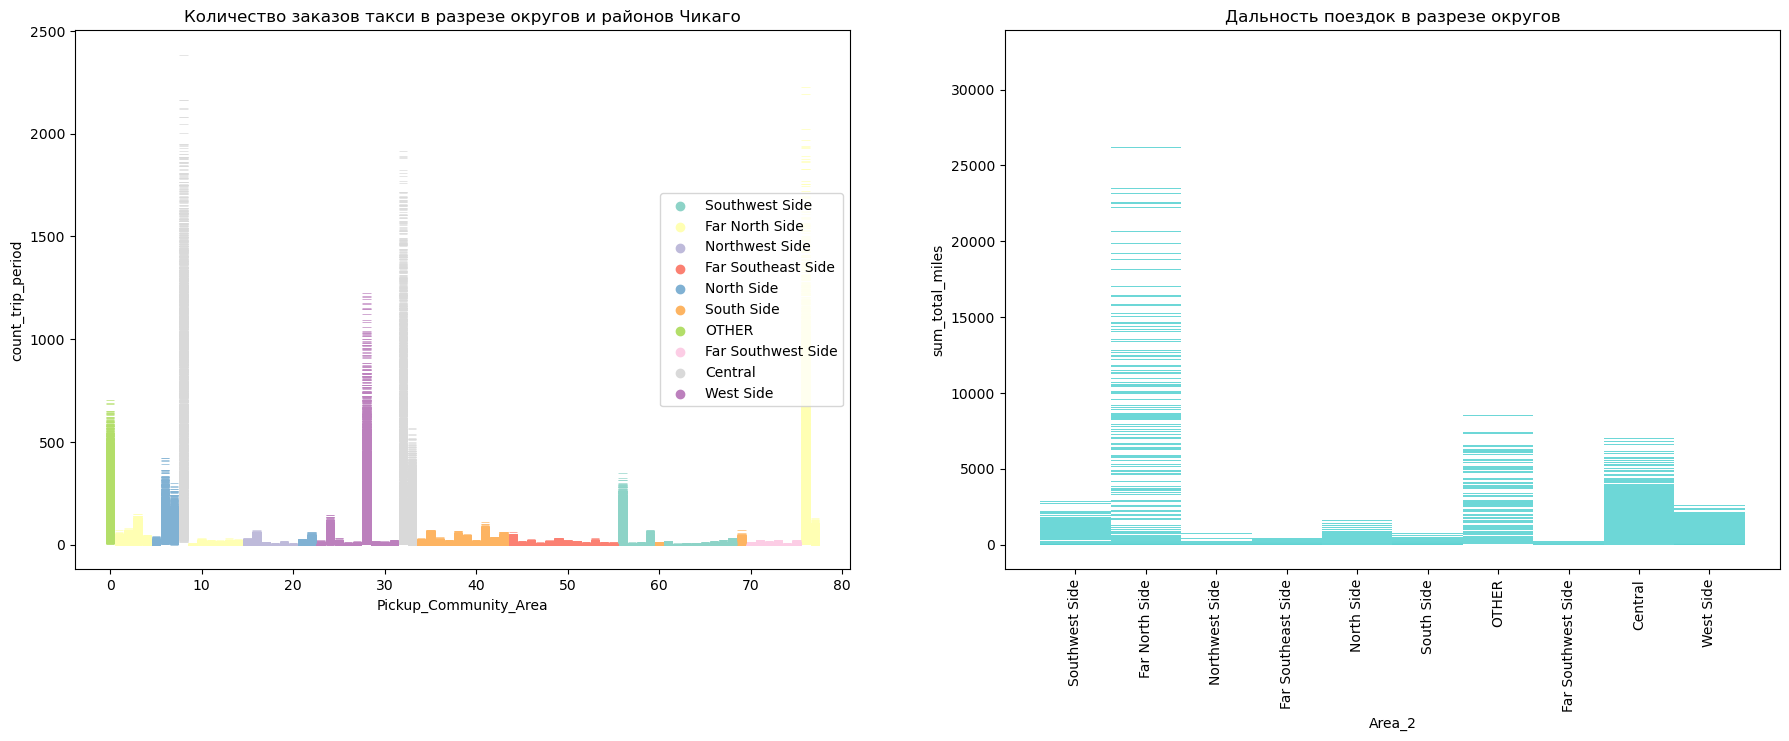

In [ ]:
plt.figure(figsize=(22, 7))

plt.subplot(1, 2, 1)
plt.title('Количество заказов такси в разрезе округов и районов Чикаго')
sns.scatterplot(df_all_interval_weekdays,x = 'Pickup_Community_Area', y = 'count_trip_period', hue = 'Area_2', palette = 'Set3', marker = '_')
plt.legend(loc = 7)

plt.subplot(1, 2, 2)
plt.title('Дальность поездок в разрезе округов')
sns.histplot(df_all_interval_weekdays,x = 'Area_2', y = 'sum_total_miles', color = 'teal')
plt.xticks(rotation=90)

plt.show()

Посмотрим теперь в разрезе макрозон Чикаго. Большее количество заказов наблюдается в Central, Far North Side, West Side. При это дальность поездки больше из округа Far North Side. Как видно на карте ниже, это один из самыч удаленных от центра округов.

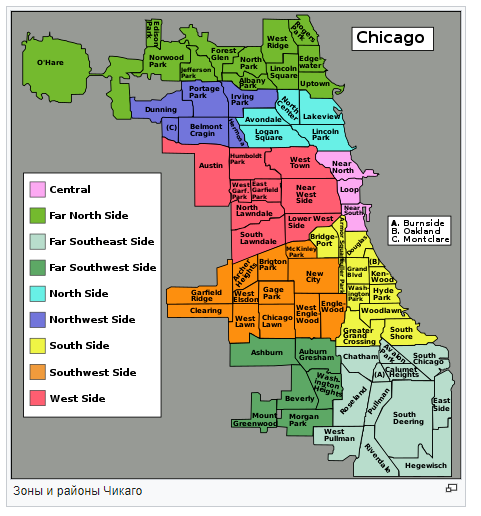

In [ ]:
df_areas_macro = df_all.filter((F.col('Pickup Centroid Latitude').isNotNull())&(F.col('Dropoff Centroid Latitude').isNotNull()))\
                       .select('Pickup Centroid Latitude', 'Pickup Centroid Longitude',
                               'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude')\
                       .groupBy('Pickup Centroid Latitude', 'Pickup Centroid Longitude',
                               'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude').agg(F.count('Pickup Centroid Latitude')).toPandas()

In [ ]:
chicago_coor = (41.88, -87.62)
chicago_loc = df_areas_macro[['Pickup Centroid Latitude', 'Pickup Centroid Longitude']]

map = folium.Map(location=chicago_coor, zoom_start=12)
cluster = folium.plugins.MarkerCluster().add_to(map)
for i, each in enumerate(chicago_loc.iterrows()):
    location = [each[1]['Pickup Centroid Latitude'],each[1]['Pickup Centroid Longitude']]
    folium.Marker(location=location, popup=str(i)).add_to(cluster)
folium.LayerControl(collapsed=False).add_to(map)
display(map)

In [ ]:
chicago_loc = df_areas_macro[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']]
for i, each in enumerate(chicago_loc.iterrows()):
    location = [each[1]['Dropoff Centroid Latitude'],each[1]['Dropoff Centroid Longitude']]
    folium.Marker(location=location, popup=str(i)).add_to(cluster)
folium.LayerControl(collapsed=False).add_to(map)
display(map)

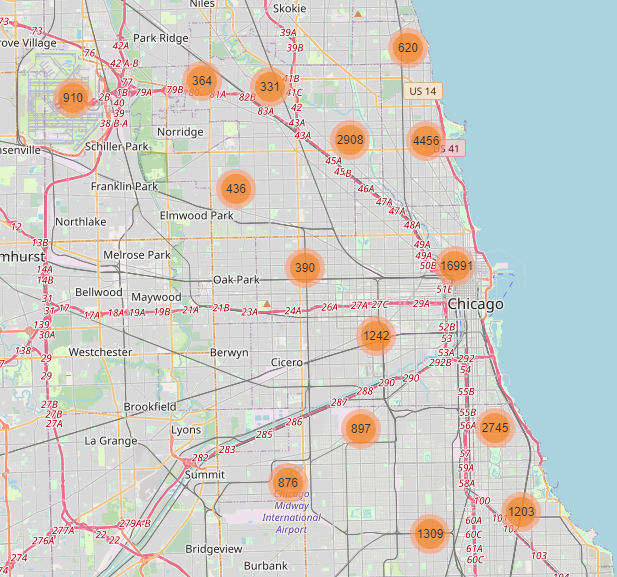

Основные пункты назначения - центральная часть города и 2 аэропорта (О хара и Мидвэй).

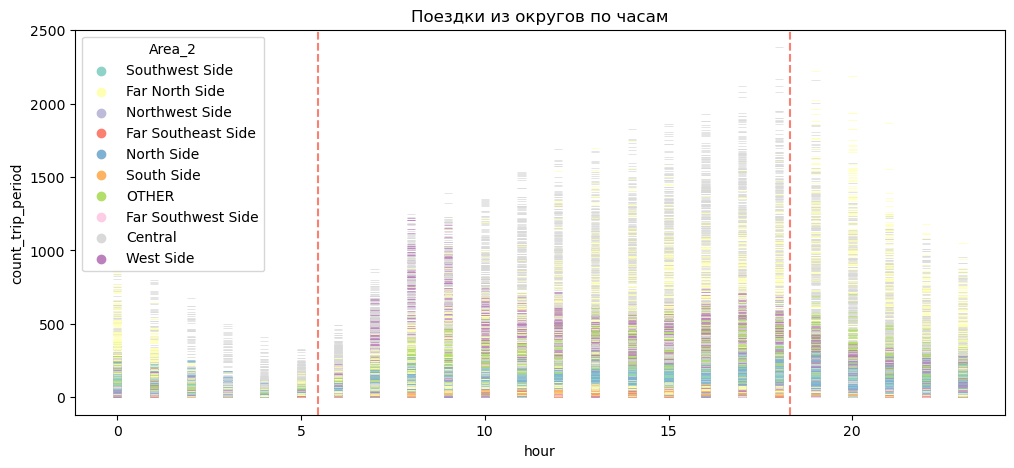

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('Поездки из округов по часам')
sns.scatterplot(df_all_interval_weekdays, x = 'hour', y = 'count_trip_period', hue = 'Area_2', palette = 'Set3', marker = '_')
plt.axvline(x=5.45, color='salmon', linestyle = '--')
plt.axvline(x=18.3, color='salmon', linestyle = '--')
plt.show()

Посмотрим теперь по часам откуда чаще всего жители Чикаго заказывают такси.
В рабочее время утром преобладает заказ такси из West Side (предположительно из спального района в центр). А в течение рабочего дня и ночью - Central, Far North Side. Вспомним, именно в этих районах находятся аэропорты.

In [ ]:
def show_graf(column):

    plt.figure(figsize=(22, 5))

    plt.subplot(1, 3, 1)
    plt.title(f'Среднее количество поездок в разрезе {column}')
    sns.histplot(data=df_all_interval_weekdays, x = column, y= 'count_mean_trip', color = 'cornflowerblue')
    sns.lineplot(data=df_all_interval_weekdays, y = df_all_interval_weekdays['count_mean_trip'].mean(), x = column, \
             color = 'salmon', style=True, dashes=[(3,3)])
    plt.legend(['mean_value'])
    plt.ylim(0,500)

    plt.subplot(1, 3, 2)
    plt.title(f'Средняя дальность поездок в разрезе {column}')
    sns.histplot(data=df_all_interval_weekdays, x = column, y= 'avg_miles_trip', color = 'tan')
    sns.lineplot(data=df_all_interval_weekdays, y = df_all_interval_weekdays['avg_miles_trip'].mean(), x = column, \
                 color = 'salmon', style=True, dashes=[(3,3)])
    plt.legend(['mean_value'])
    plt.ylim(0,50)

    plt.subplot(1, 3, 3)
    plt.title(f'Средняя стоимость поездки в разрезе {column}')
    sns.histplot(data=df_all_interval_weekdays, y = 'avg_price_trip', x = column, color = 'teal',)
    sns.lineplot(data=df_all_interval_weekdays, y = df_all_interval_weekdays['avg_price_trip'].mean(), x = column, \
                 color = 'salmon', style=True, dashes=[(3,3)])
    plt.legend(['mean_value'])
    plt.ylim(0,120)

    plt.show()

Посмотрим как среднее число поездок, средняя дальность поездки и срений чек меняются в зависимости от сезона, дня недели и часа.

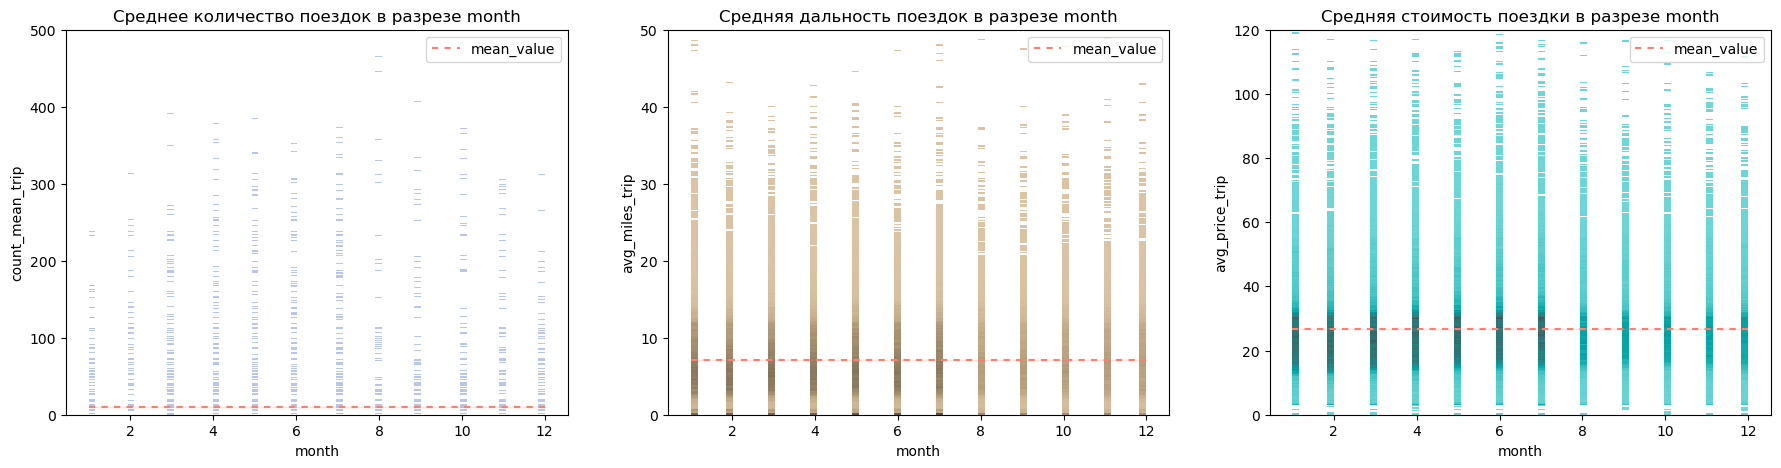

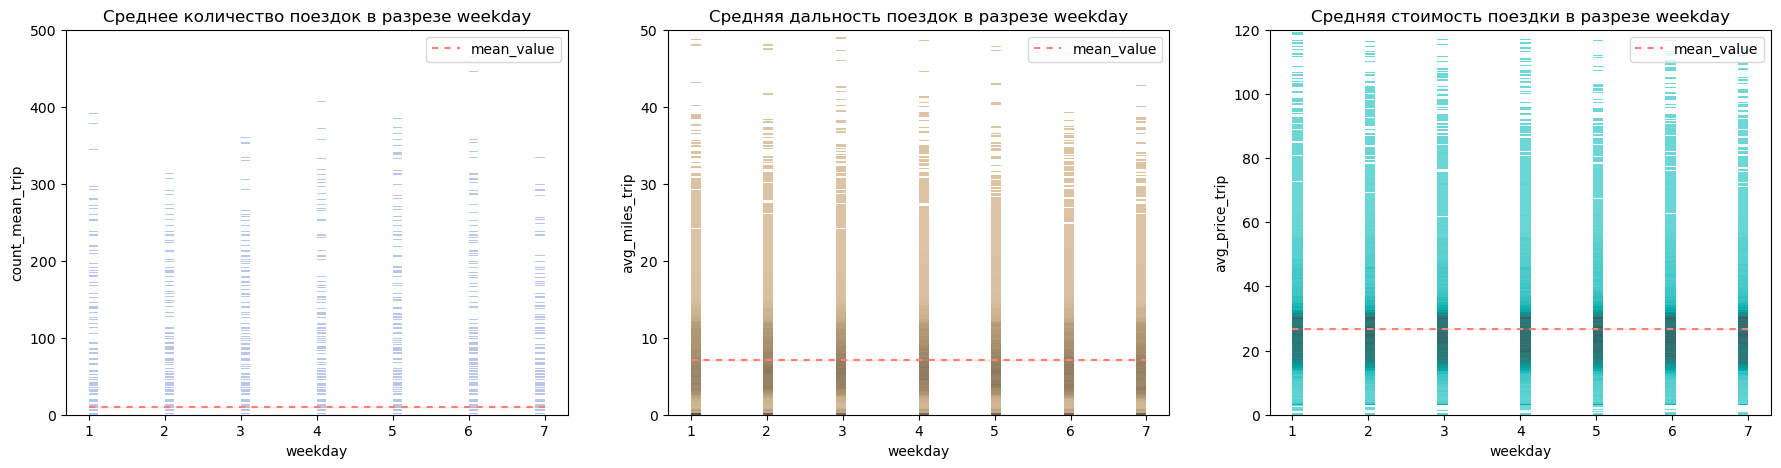

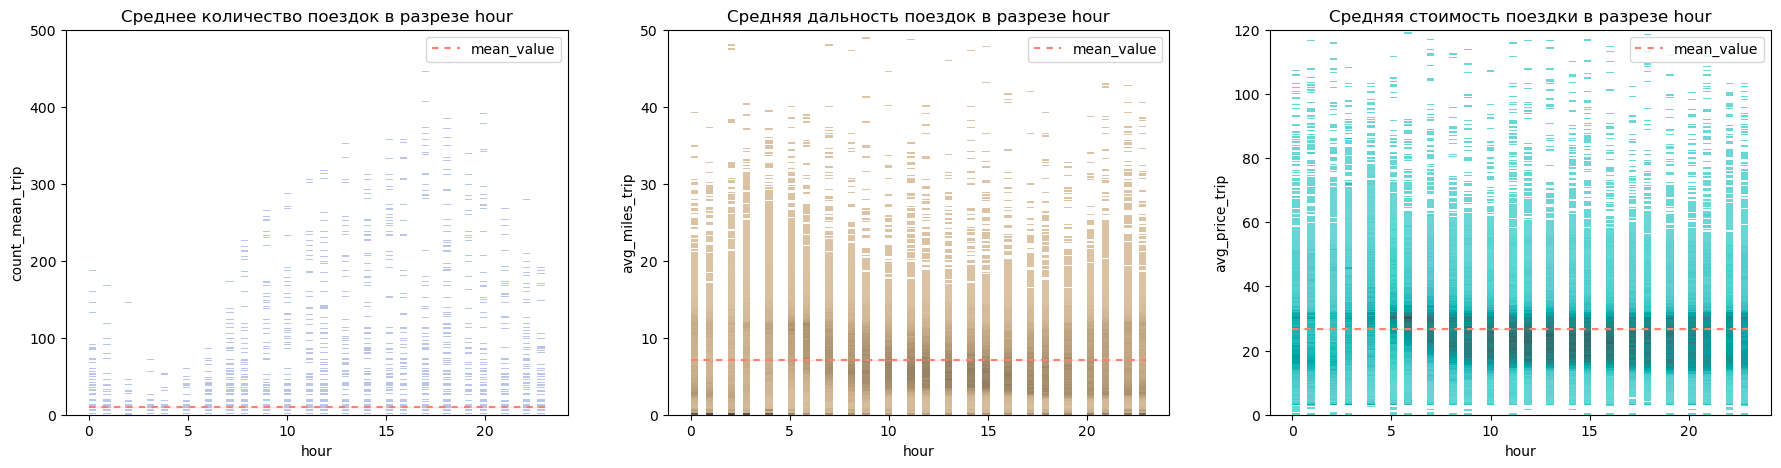

In [ ]:
for column in ['month', 'weekday', 'hour']:
    show_graf(column)

Какую полезную информацию мы можем подчерпнуть из данных:
 - Основные часы-пик для таксистов - с 17-21 часа
 - Ночью дальность поездок увеличивается
 - В январе, июле, декабре дальность поездок увеличивается. Возможно это связано с праздниками.
 - Стоимость поездки возрастает в ночные часы и в восресение.

Напомню, что воскресение - 1 день недели!

In [ ]:
df_all_interval_date = data.groupBy(['Date_H','tmpf_new','sknt_new','vis1_coeff_new', 'ptype','precip'])\
                               .agg(F.sum('Count_Trip').alias('count_trip_period'),\
                                    F.mean('Count_Trip').alias('count_mean_trip'),\
                                    F.sum('Sum_Trip_Cost').alias('sum_total_trip'))\
                               .withColumn('avg_price_trip', F.col('sum_total_trip')/F.col('count_trip_period')).toPandas()
df_all_interval_date.head(5)

,Date_H,tmpf_new,sknt_new,vis1_coeff_new,ptype,precip,count_trip_period,count_mean_trip,sum_total_trip,avg_price_trip
0,01.05.2022 13,55.0,8.0,0.050,NP,0.0,719,9.217949,15726.763559,21.873106
1,01.08.2023 13,43.0,8.0,0.090,unknown,0.0,531,6.807692,15726.979661,29.617664
2,01.10.2023 09,43.0,8.0,0.090,unknown,0.0,985,12.628205,20396.038305,20.706638
3,01.12.2023 08,43.0,8.0,0.090,unknown,0.0,972,12.461538,19020.210000,19.568117
4,01.22.2022 05,54.0,9.0,0.064,unknown,0.0,82,1.051282,2380.050000,29.025000


In [ ]:
def show_w_graf(column):
    plt.figure(figsize=(22, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Количество заказов в зависимости от {column}')
    sns.histplot(df_all_interval_date, y = column, color = 'salmon', alpha = 1)
    sns.histplot(df_all_interval_date, x = 'count_mean_trip', y = column, color = 'cornflowerblue')
    plt.xlim(0,30)


    plt.subplot(1, 2, 2)
    plt.title(f'Средняя цена за поездку в зависимости от {column}')
    sns.scatterplot(df_all_interval_date, x = 'avg_price_trip', y = column, color = 'cornflowerblue')
    plt.xlim(10,80)
    plt.show()

Наложим данные о погоде на количество заказов и средний чек за поездку.

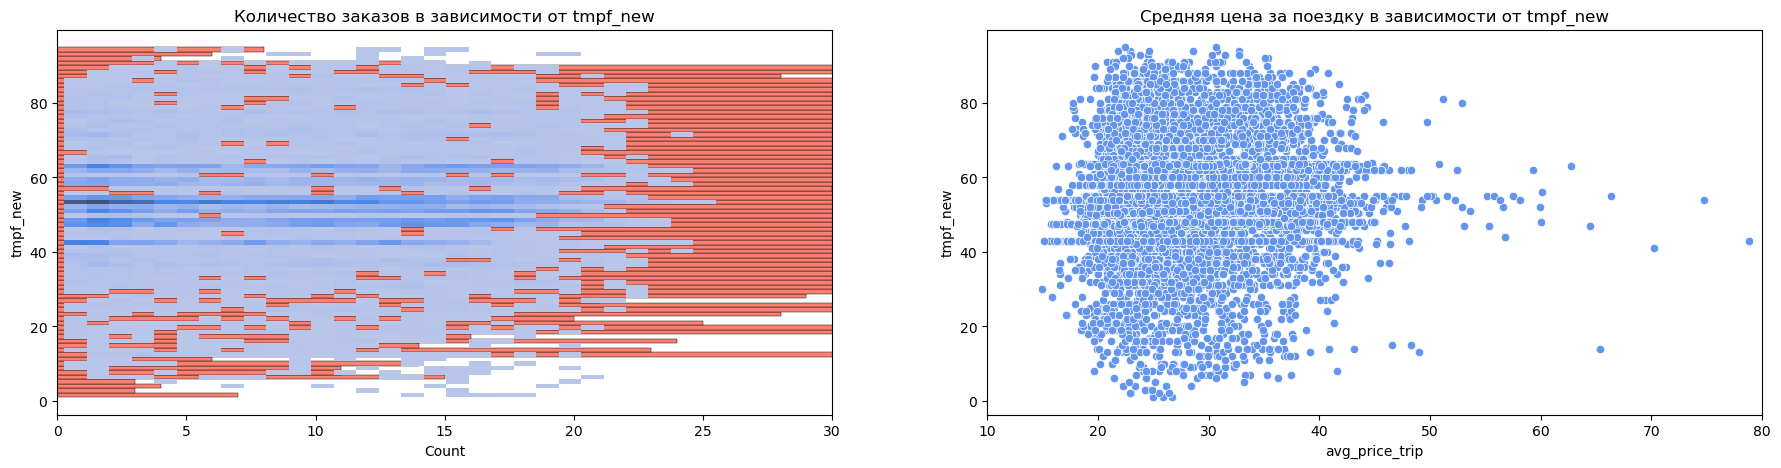

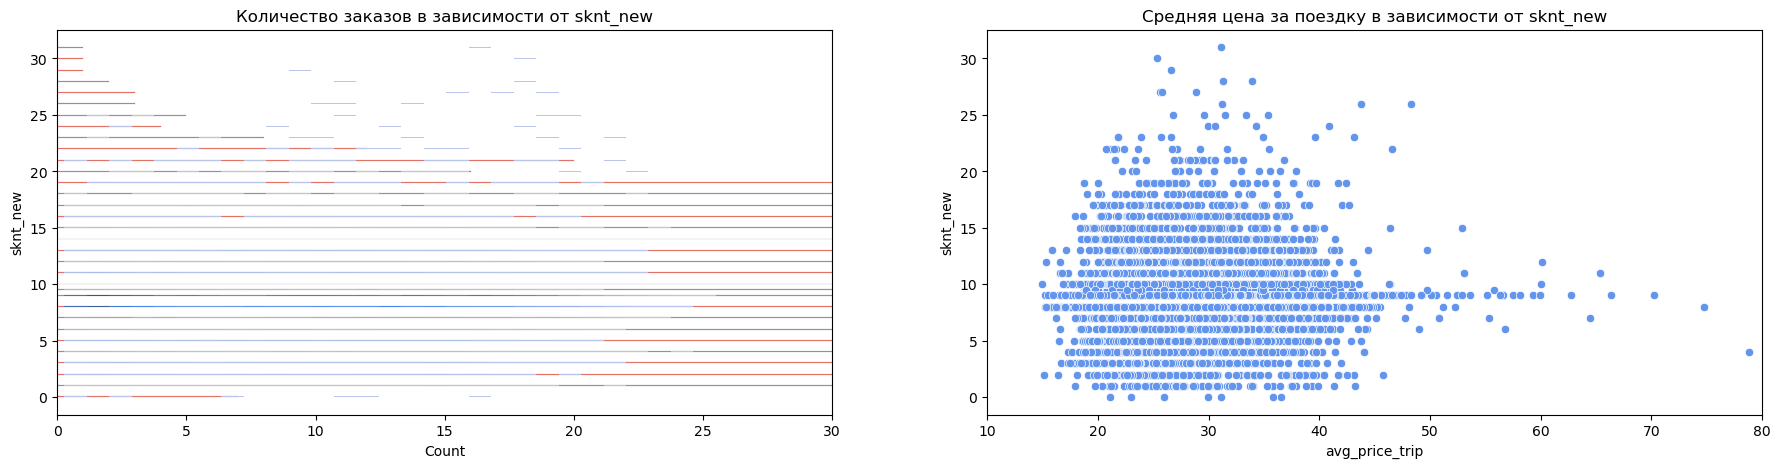

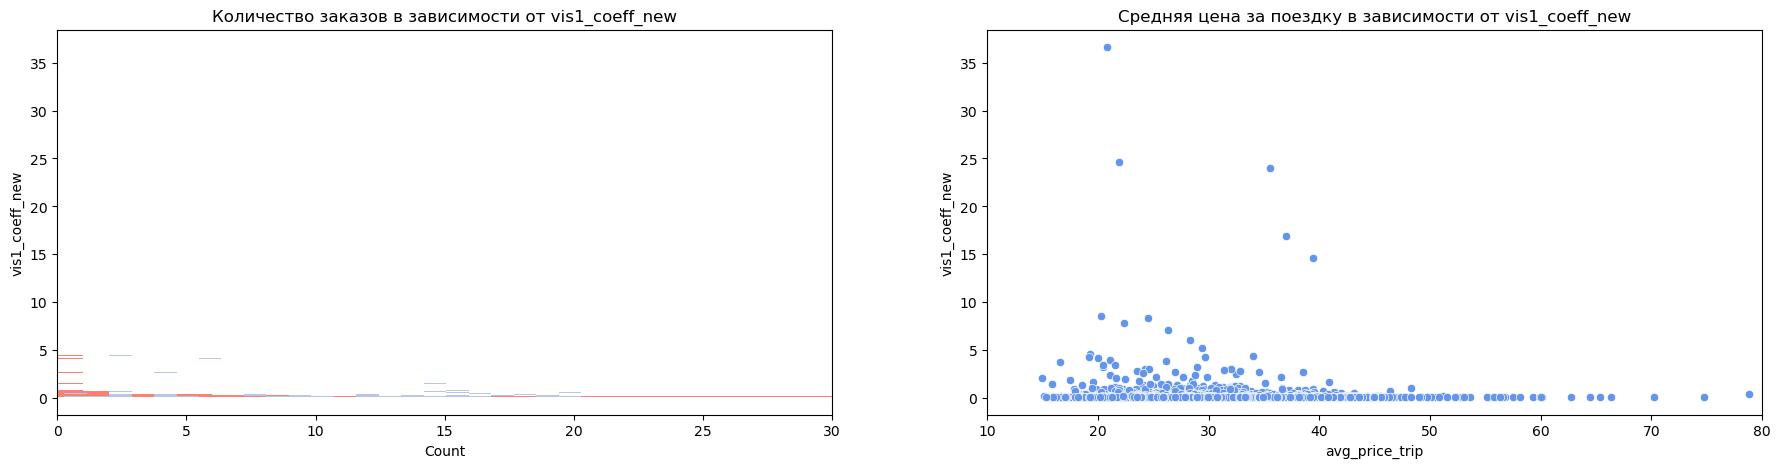

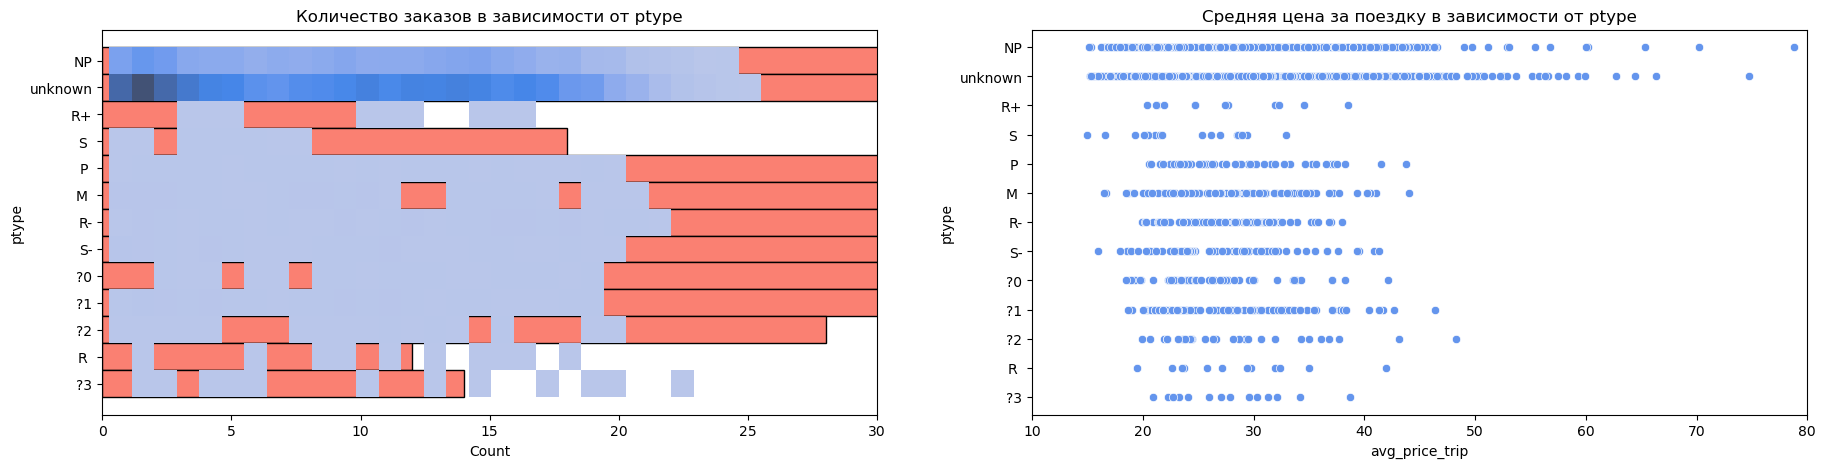

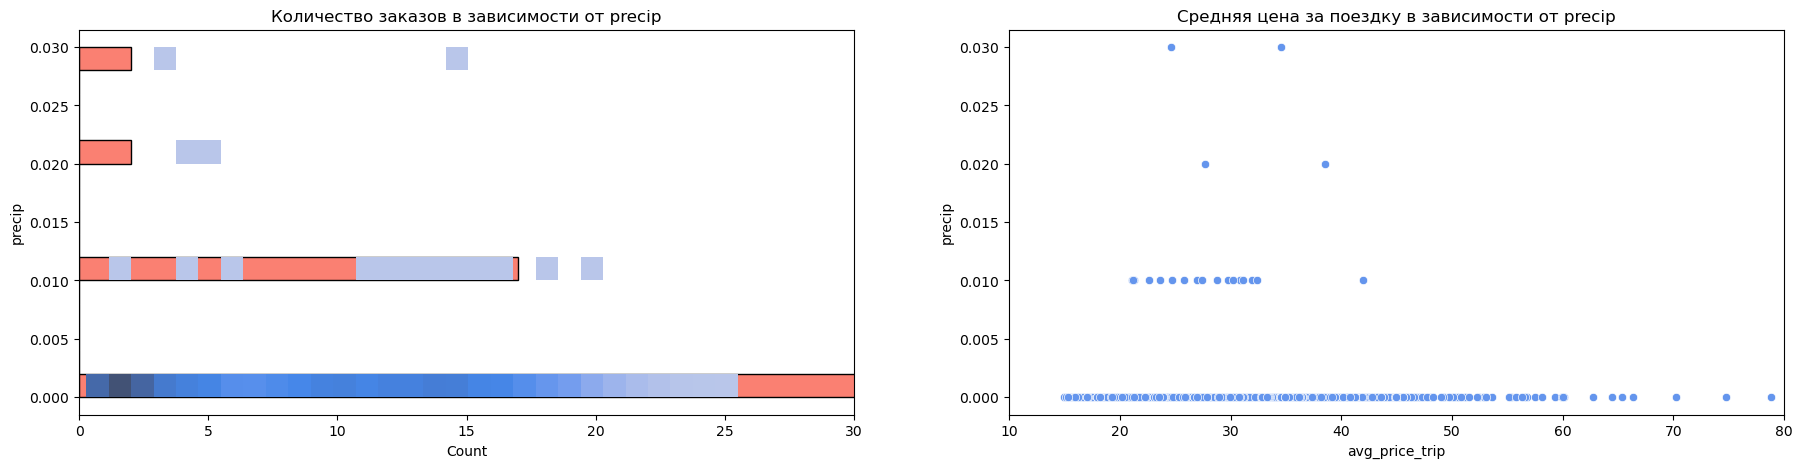

In [ ]:
for column in ['tmpf_new', 'sknt_new','vis1_coeff_new','ptype','precip']:
    show_w_graf(column)

В принципе здесь явной зависимости не видно.

Предположим, что в выходные или праздничные дни поездок на такси совершается меньше. Получим данные о всех государственных праздниках в США.

In [ ]:
holidays.HolidayBase()
USA_holidays_list = holidays.US()
list_holidays = []
for year in [2022, 2023]:
    for p in holidays.US(years = year).items():
        list_holidays.append(p[0].isoformat())
list_holidays[:5]

['2022-01-17', '2022-02-21', '2022-10-10', '2022-01-01', '2022-05-30']

Воскресенье - 1 день недели. Можно добавить 2 новых признака - праздник или нет, выходной или нет.

In [ ]:
data = data.withColumn('holidays', F.when((F.col('Date').isin(list_holidays)), 1).otherwise(0)) \
           .withColumn('day_off', F.when((F.col('weekday').isin([1,7])), 1).otherwise(0))

Неплохо было бы посмотреть как коррелируют между собой наши числовые признаки

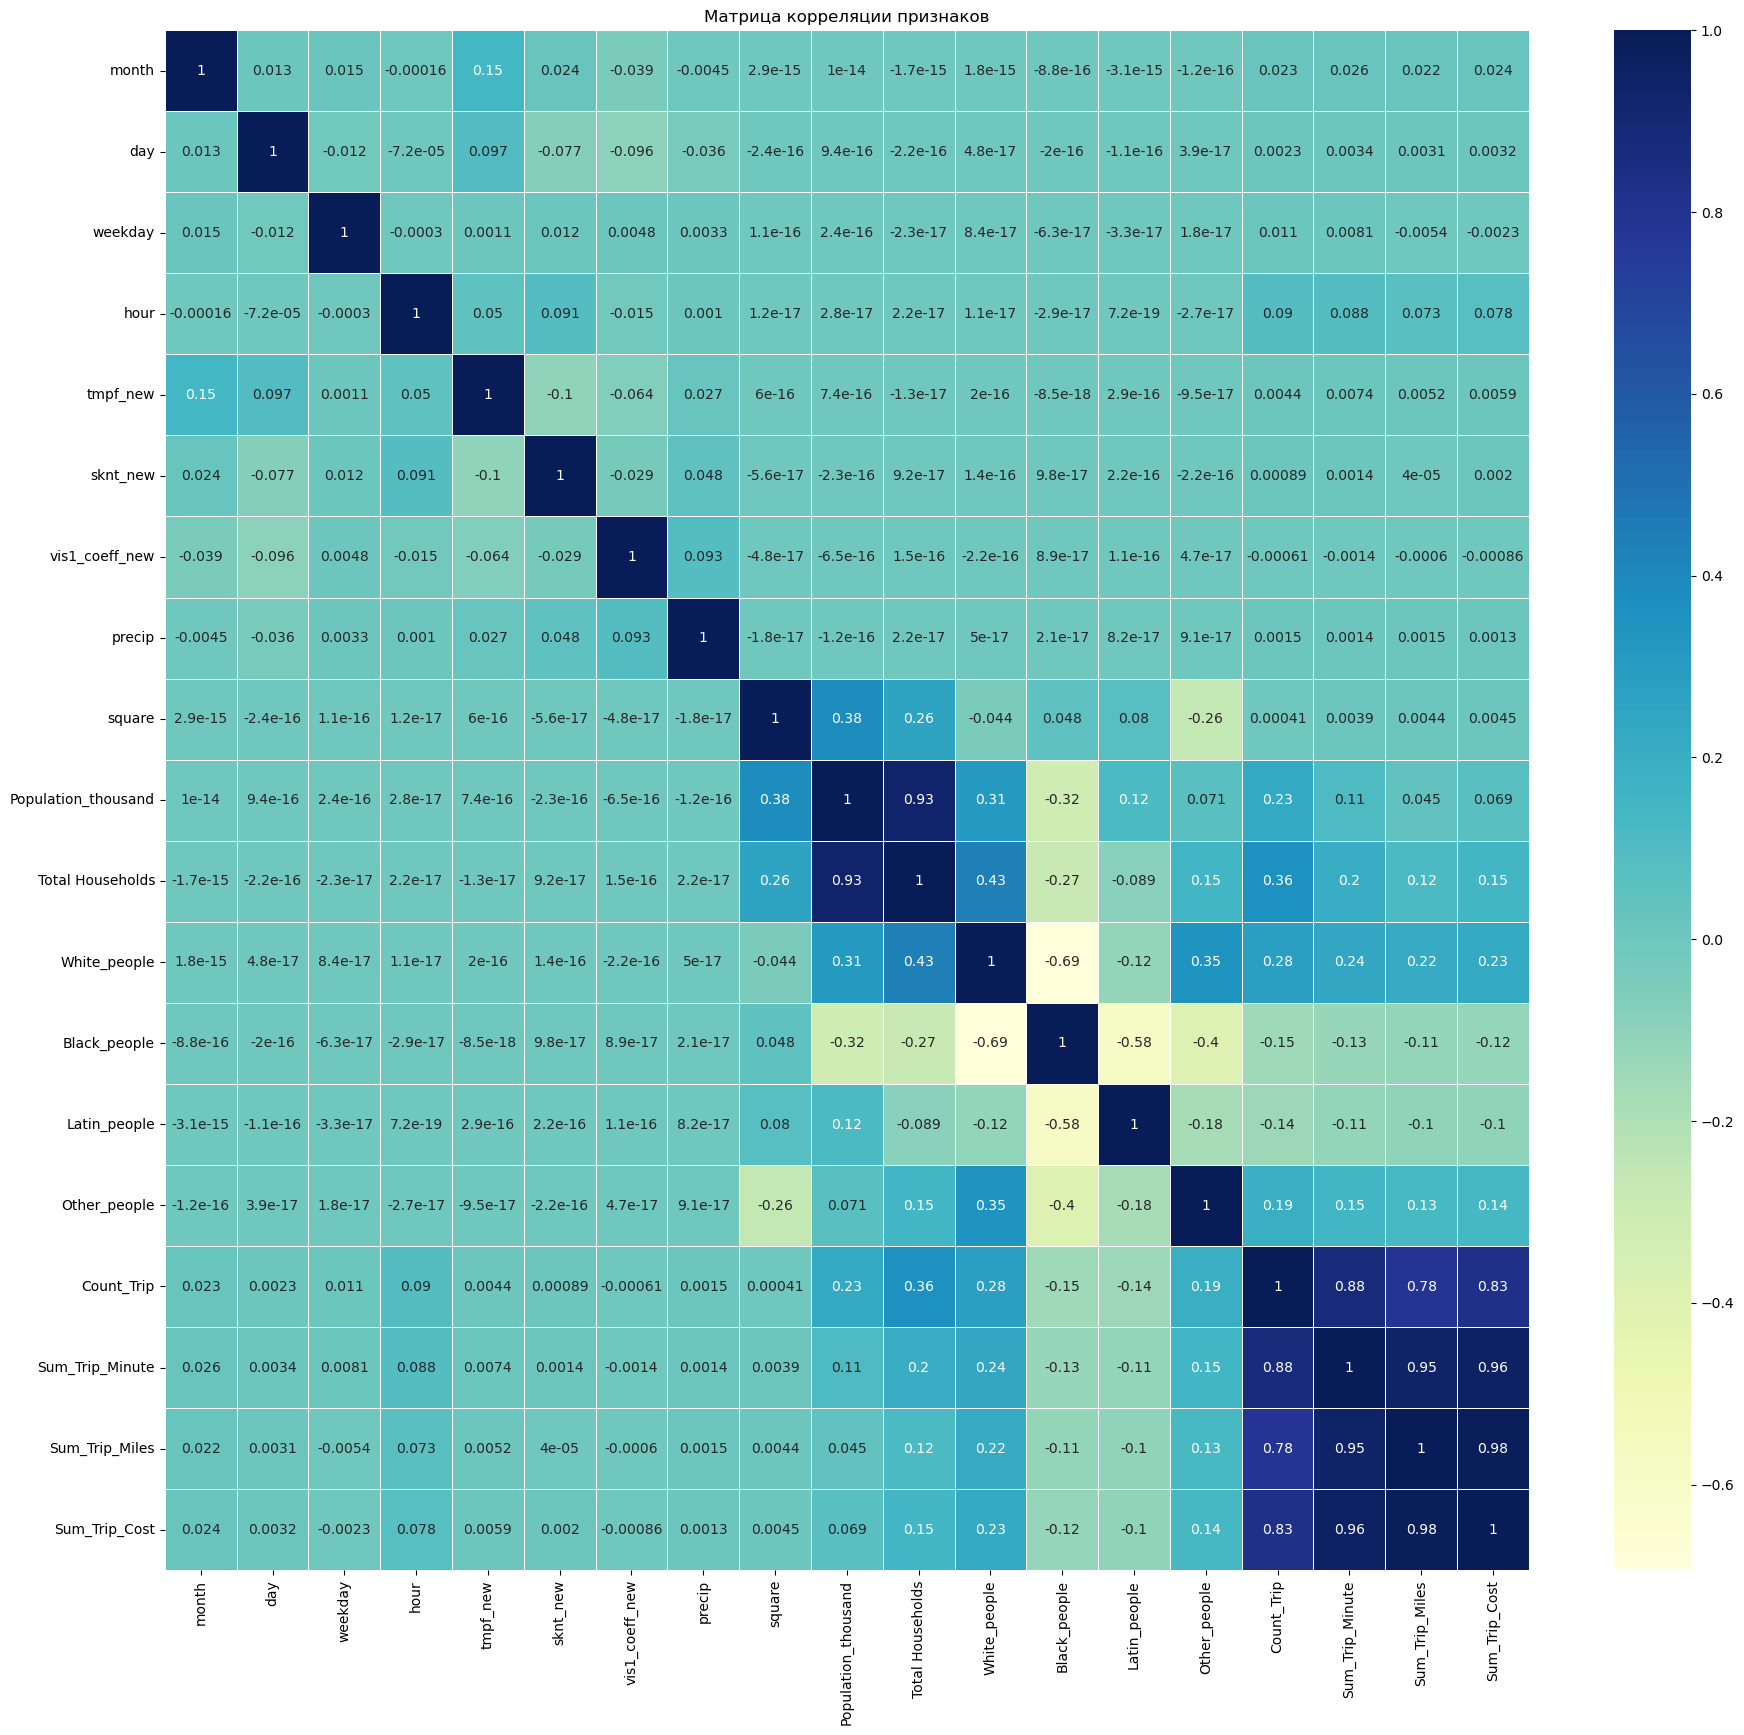

In [ ]:
num_col = ['month','day','weekday','hour','tmpf_new', 'sknt_new',
 'vis1_coeff_new','precip','square','Population_thousand','Total Households','White_people',
 'Black_people','Latin_people','Other_people', 'Count_Trip','Sum_Trip_Minute','Sum_Trip_Miles','Sum_Trip_Cost']

f, ax = plt.subplots(figsize=(22, 20))
g = sns.heatmap(data.select(num_col).toPandas().corr(), annot=True, linewidths=.5, ax=ax, cmap = 'YlGnBu')
plt.title('Матрица корреляции признаков')
plt.show()

Хоть на предыдущих графиках взаимосвязь между этнической пренадлежностью и поездками на такси не была столь очевидна, но все же умеренная корреляция между ними есть. Так же как и с численностью населения. Создадим новый признак, который позволит рассчитать количество поездок на 1 белого и азиата (группа прочие) в районе на определенный час. Еще нам пригодится средний чек за минуту поездки и среднее время поездки. Рассчитаем их.

In [ ]:
dff = data.groupBy(['Pickup_Community_Area', 'hour', 'Population_thousand', 'White_people', 'Other_people'])\
          .agg(F.sum('Count_Trip').alias('sum_count_trip'))\
          .withColumn('avg_count_for_white_people', (F.col('Population_thousand')*F.col('White_people'))/F.col('sum_count_trip'))\
          .withColumn('avg_count_for_other_people', (F.col('Population_thousand')*F.col('Other_people'))/F.col('sum_count_trip'))
dff.show(2)

data = data.join(dff.select(['Pickup_Community_Area', 'hour', 'avg_count_for_white_people', 'avg_count_for_other_people']), how = 'left', on = ['Pickup_Community_Area', 'hour'])\
           .withColumn('avg_price', F.col('Sum_Trip_Cost')/F.col('Count_Trip'))\
           .withColumn('avg_time', F.col('Sum_Trip_Minute')/F.col('Count_Trip'))\
           .withColumn('avg_time_mitute', F.col('avg_price')/F.col('avg_time')).fillna(0)\
           .withColumn('cost_white_people', F.col('avg_count_for_white_people')*F.col('avg_time_mitute'))\
           .withColumn('cost_other_people', F.col('avg_count_for_other_people')*F.col('avg_time_mitute'))

+---------------------+----+-------------------+------------+------------+--------------+--------------------------+--------------------------+
|Pickup_Community_Area|hour|Population_thousand|White_people|Other_people|sum_count_trip|avg_count_for_white_people|avg_count_for_other_people|
+---------------------+----+-------------------+------------+------------+--------------+--------------------------+--------------------------+
|                   67|  21|             29.647|       0.013|       0.021|           270|      0.001427448148148148|      0.002305877777777778|
|                   41|  11|             29.456|       0.467|       0.213|          4810|      0.002859865280665281|      0.001304392515592...|
+---------------------+----+-------------------+------------+------------+--------------+--------------------------+--------------------------+
only showing top 2 rows



Добавим в наши данные следующие признаки:
 - скользящее среднее за 3 часа по количеству заказов
 - скользящее среднее за 3 часа по среднему чеку за минуту
 - скользящее среднее за 3 часа по времени поездки
 - скользящее среднее за 3 часа количество поездок на 1 белого
 - скользящее среднее за 3 часа количество поездок на 1 азиата

In [ ]:
for value in (-3,):
    window = Window.partitionBy('Pickup_Community_Area').orderBy(F.col('Date_H')).rowsBetween(value,-1)
    data = data.withColumn(f'rolling_avg_{abs(value)}', F.avg('Count_Trip').over(window))\
               .withColumn(f'rolling_avg_price_{abs(value)}', F.avg('avg_time_mitute').over(window))\
               .withColumn(f'rolling_avg_time_{abs(value)}', F.avg('avg_time').over(window))\
               .withColumn(f'rolling_cost_white_people_{abs(value)}', F.avg('cost_white_people').over(window))\
               .withColumn(f'rolling_cost_other_people_{abs(value)}', F.avg('cost_other_people').over(window))

data.filter((F.col('Date')=='2022-01-01')&(F.col('Pickup_Community_Area')==2)).select(['Pickup_Community_Area','Date_H', 'Count_Trip', 'rolling_avg_3']).show(24)

+---------------------+-------------+----------+------------------+
|Pickup_Community_Area|       Date_H|Count_Trip|     rolling_avg_3|
+---------------------+-------------+----------+------------------+
|                    2|01.01.2022 00|         3|              null|
|                    2|01.01.2022 01|         2|               3.0|
|                    2|01.01.2022 02|         3|               2.5|
|                    2|01.01.2022 03|         0|2.6666666666666665|
|                    2|01.01.2022 04|         0|1.6666666666666667|
|                    2|01.01.2022 05|         4|               1.0|
|                    2|01.01.2022 06|         3|1.3333333333333333|
|                    2|01.01.2022 07|         3|2.3333333333333335|
|                    2|01.01.2022 08|         2|3.3333333333333335|
|                    2|01.01.2022 09|         4|2.6666666666666665|
|                    2|01.01.2022 10|         2|               3.0|
|                    2|01.01.2022 11|         7|

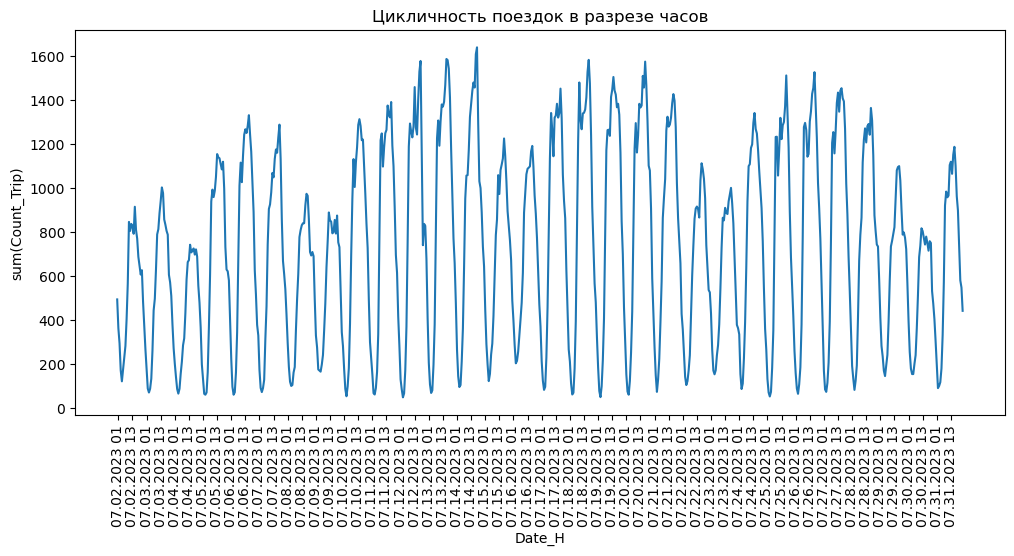

In [ ]:
dff = data.filter((F.col('Date')>'2023-07-01'))\
          .groupBy('Date_H').agg(F.sum('Count_Trip')).orderBy('Date_H').toPandas()

plt.figure(figsize=(12, 5))
plt.title('Цикличность поездок в разрезе часов')
sns.lineplot(dff, x = 'Date_H', y = 'sum(Count_Trip)')
ticks, _ = plt.xticks()
plt.xticks(ticks[1:-1:12], rotation=90)
plt.show()

Добавим лаги по количеству поездок и среднему чеку за 24 часа.

In [ ]:
for value in range(1,25):
    window = Window.partitionBy('Pickup_Community_Area').orderBy(F.col('Date_H'))
    data = data.withColumn(f'lag_{value}', F.lag('Count_Trip', value).over(window))\
               .withColumn(f'lag_price_{value}', F.lag('avg_time_mitute', value).over(window))

data.filter((F.col('Date')=='2022-01-01')&(F.col('Pickup_Community_Area')==2)).select(['Pickup_Community_Area','Date_H', 'Count_Trip', 'lag_1', 'lag_3', 'lag_6']).show(24)

+---------------------+-------------+----------+-----+-----+-----+
|Pickup_Community_Area|       Date_H|Count_Trip|lag_1|lag_3|lag_6|
+---------------------+-------------+----------+-----+-----+-----+
|                    2|01.01.2022 00|         3| null| null| null|
|                    2|01.01.2022 01|         2|    3| null| null|
|                    2|01.01.2022 02|         3|    2| null| null|
|                    2|01.01.2022 03|         0|    3|    3| null|
|                    2|01.01.2022 04|         0|    0|    2| null|
|                    2|01.01.2022 05|         4|    0|    3| null|
|                    2|01.01.2022 06|         3|    4|    0|    3|
|                    2|01.01.2022 07|         3|    3|    0|    2|
|                    2|01.01.2022 08|         2|    3|    4|    3|
|                    2|01.01.2022 09|         4|    2|    3|    0|
|                    2|01.01.2022 10|         2|    4|    3|    0|
|                    2|01.01.2022 11|         7|    2|    2|  

In [ ]:
num_cols = ['hour','year','month','day','weekday','Population_thousand','Total Households','White_people',
           'Other_people','holidays','day_off','rolling_avg_3','rolling_avg_price_3','lag_1','lag_price_1','lag_2',
           'lag_price_2','lag_3','lag_price_3','lag_4','lag_price_4','lag_5','lag_price_5','lag_6','lag_price_6',
           'lag_7','lag_price_7','lag_8','lag_price_8','lag_9','lag_price_9','lag_10','lag_price_10','rolling_avg_time_3',
           'rolling_cost_white_people_3','rolling_cost_other_people_3',
           'lag_11','lag_price_11','lag_12','lag_price_12','lag_13','lag_price_13','lag_14','lag_price_14','lag_15',
           'lag_price_15','lag_16','lag_price_16','lag_17','lag_price_17','lag_18','lag_price_18','lag_19',
           'lag_price_19','lag_20','lag_price_20','lag_21','lag_price_21','lag_22','lag_price_22','lag_23',
           'lag_price_23','lag_24','lag_price_24'
]
cat_cols = ['Area_2', 'Pickup_Community_Area']

Ленивые вычисления - стратегия вычисления, согласно которой вычисления следует откладывать до тех пор, пока не понадобится их результат. Ленивое вычисление в Spark означает, что выполнение не начнется, пока не будет запущен Action. В Spark ленивые вычисления возникают, когда описываются преобразования. Поэтому для усколрения обучения нам потребуется записать все результаты предыдущих преобразований датафрейма в одельный файл.

In [ ]:
select_columns = num_cols+cat_cols+['Date_H', 'Date','Count_Trip']
df_write = data.select(select_columns).toPandas()
df_write.to_csv('output.csv', index=False)

## 3. Обучение

Подготовим все для обучения.

### 3.0. Подготовка к обучению

In [ ]:
#разделение на выборки
def train_test_split(df):
    train_data = df.filter(F.col('Date')<'2023-05-01')\
                     .orderBy('Date_H').select(['Date_H', 'features', 'Count_Trip'])
    valid_data = df.filter((F.col('Date')>='2023-05-01')&(F.col('Date')<'2023-07-01'))\
                     .orderBy('Date_H').select(['Date_H', 'features', 'Count_Trip'])
    test_data = df.filter(F.col('Date')>='2023-07-01')\
                     .orderBy('Date_H').select(['Date_H', 'features', 'Count_Trip'])
    return train_data, valid_data, test_data

Здесь логика такая: мы помним, что в спарке вычисления откладываются до момента их активации. Поэтому все преобразования будем проводить с отфильтрованными по районам датафреймами, а не полностью целиком. Если этого не сделать время обучения для каждого района будет равно времени обучения для всей выборки.


В данном проекте мы попробуем обучить:
 - по всей выборке целиком
 - по каждому району
 - по каждой макрозоне
   
Если мы подаем на обучение всю выборку, дополнительно будет проводится кодирование категориальных данных.

In [ ]:
#кодирование категориальных данных
indexers = [StringIndexer(inputCol=col, outputCol=f'{col}_id') for col in cat_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol='{0}_ohe'.format(indexer.getOutputCol())) for indexer in indexers]
#scaler = StandardScaler(inputCol = 'features', outputCol = 'features_scaled')

#фильтрация датафрейма, векторизация в пайплане и разделение на выборки
def preprocessing_df(df, area=None):
    if area is not None:
        if isinstance(area, (str)):
            df = df.filter(F.col('Area_2')==area)
        else:
            df = df.filter(F.col('Pickup_Community_Area')==area)
        assembler = VectorAssembler(inputCols=num_cols, outputCol='features')
        pipeline = Pipeline(stages=[assembler])
    else:
        assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]+ num_cols, outputCol='features')
        pipeline = Pipeline(stages= indexers + encoders + [assembler])# +[scaler])

    df = df.dropna()
    df = pipeline.fit(df).transform(df)
    train_data, valid_data, test_data = train_test_split(df)
    return train_data, valid_data, test_data

In [ ]:
data_new = spark.read.load('output.csv', format = 'csv', inferSchema = True, header = 'true')

In [ ]:
# просмотр результатов обучения на примере 5 дней в валидационной выборке
def show_result(predictions, name_model):
    predictions = predictions.filter(F.col('Date_H')<'05.06.2023 00').toPandas()
    predictions['prediction'] = round(predictions['prediction'],0)

    f, ax = plt.subplots(figsize=(22, 7))
    sns.despine(f, left=True, bottom=True)
    ax.bar(predictions['Date_H'], predictions['Count_Trip'], label='Факт', color = 'cornflowerblue')
    ax.bar(predictions['Date_H'], predictions['prediction'], label='Прогноз', width=0.4, color = 'gold')
    plt.legend(['Факт', 'Прогноз'])
    plt.title(f'Факт-прогноз для {model.__class__.__name__} на примере 5 дней')
    plt.xlabel('Время')
    plt.ylabel('Количество заказов')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# получить метрики
def get_metric(model, df,  area=None, show_res=None):

    predictions = model.transform(df)
    name_model = model.__class__.__name__
    evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Count_Trip')
    mae = round(evaluator.evaluate(predictions, {evaluator.metricName: 'mae'}), 2)
    rmse = round(evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}), 2)
    if area is not None:
        list_metrics.append([area, name_model, mae, rmse, model])
    else:
        list_metrics.append(['all', name_model, mae, rmse, model])
    if show_res is not None:
        show_result(predictions, name_model)

In [ ]:
list_metrics = []

# получить результат обучения
def get_result_area(model, df, area = None, show_res=None):
    train_data, valid_data, test_data = preprocessing_df(data_new, area=area)
    model_fit = model.fit(train_data)
    get_metric(model_fit, valid_data, area=area, show_res=show_res)

В качестве моделей будем использовать:
 - LinearRegression
 - GBTRegressor
 - RandomForestRegressor
 - DecisionTreeRegressor

С базовыми гиперпараметрами.

In [ ]:
models = [
    LinearRegression(labelCol = 'Count_Trip', featuresCol = 'features'),
    GBTRegressor(labelCol = 'Count_Trip', featuresCol = 'features', seed=12345, maxDepth=10),
    RandomForestRegressor(labelCol = 'Count_Trip', featuresCol = 'features', seed=12345, maxDepth=10),
    DecisionTreeRegressor(labelCol = 'Count_Trip', featuresCol = 'features', seed=12345)
]
areas = [i for i in range(0,78)]
areas_macro = ['Far North Side', 'North Side', 'Central', 'Northwest Side', 'West Side', 'South Side',
               'Far Southeast Side', 'Southwest Side', 'Far Southwest Side', 'OTHER']

### 3.1. Обучение на всей выборке

Обучим модели на всей выборке.

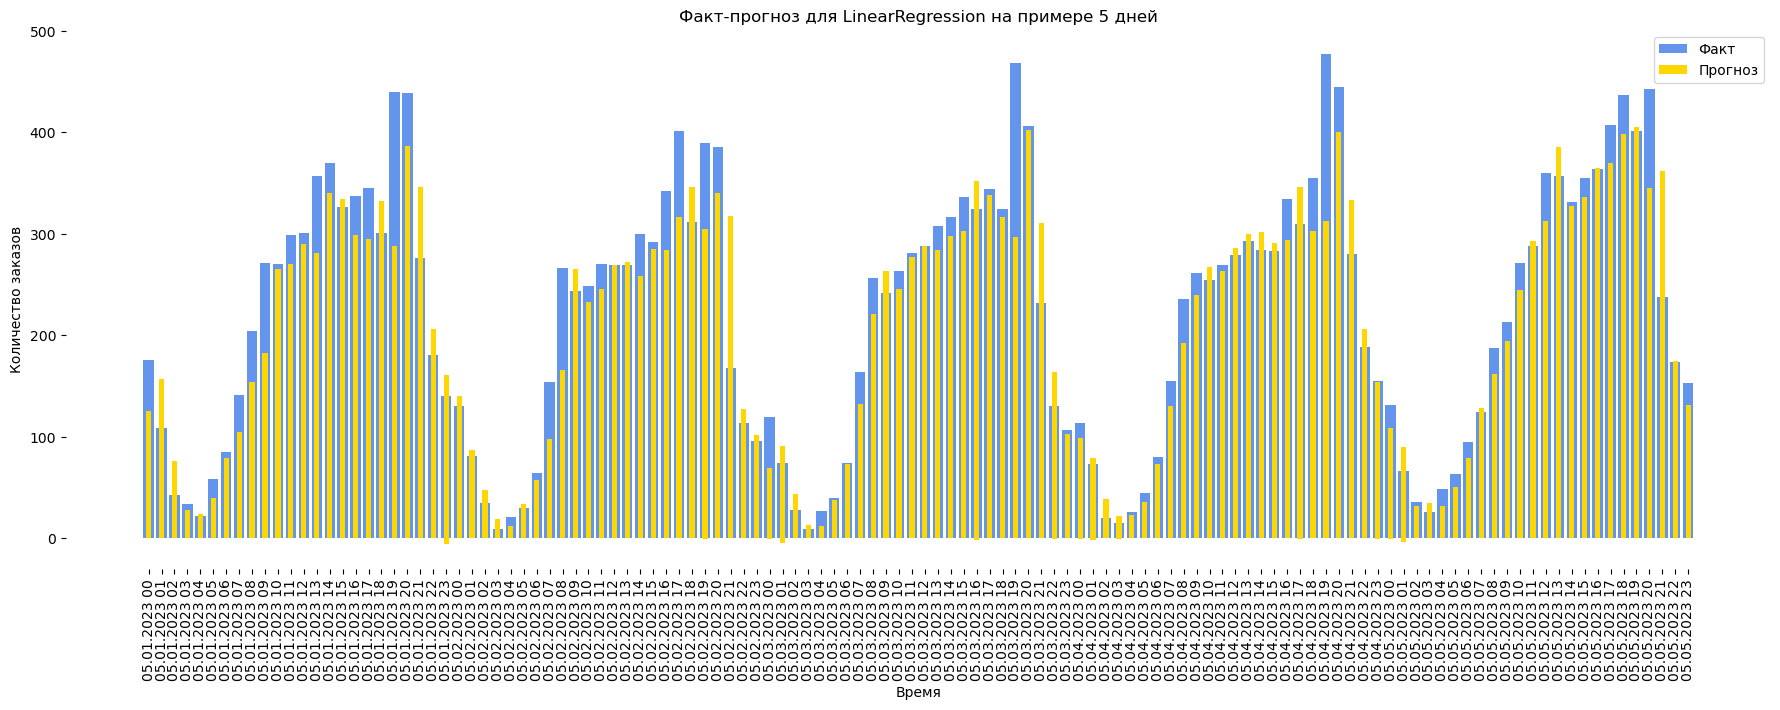

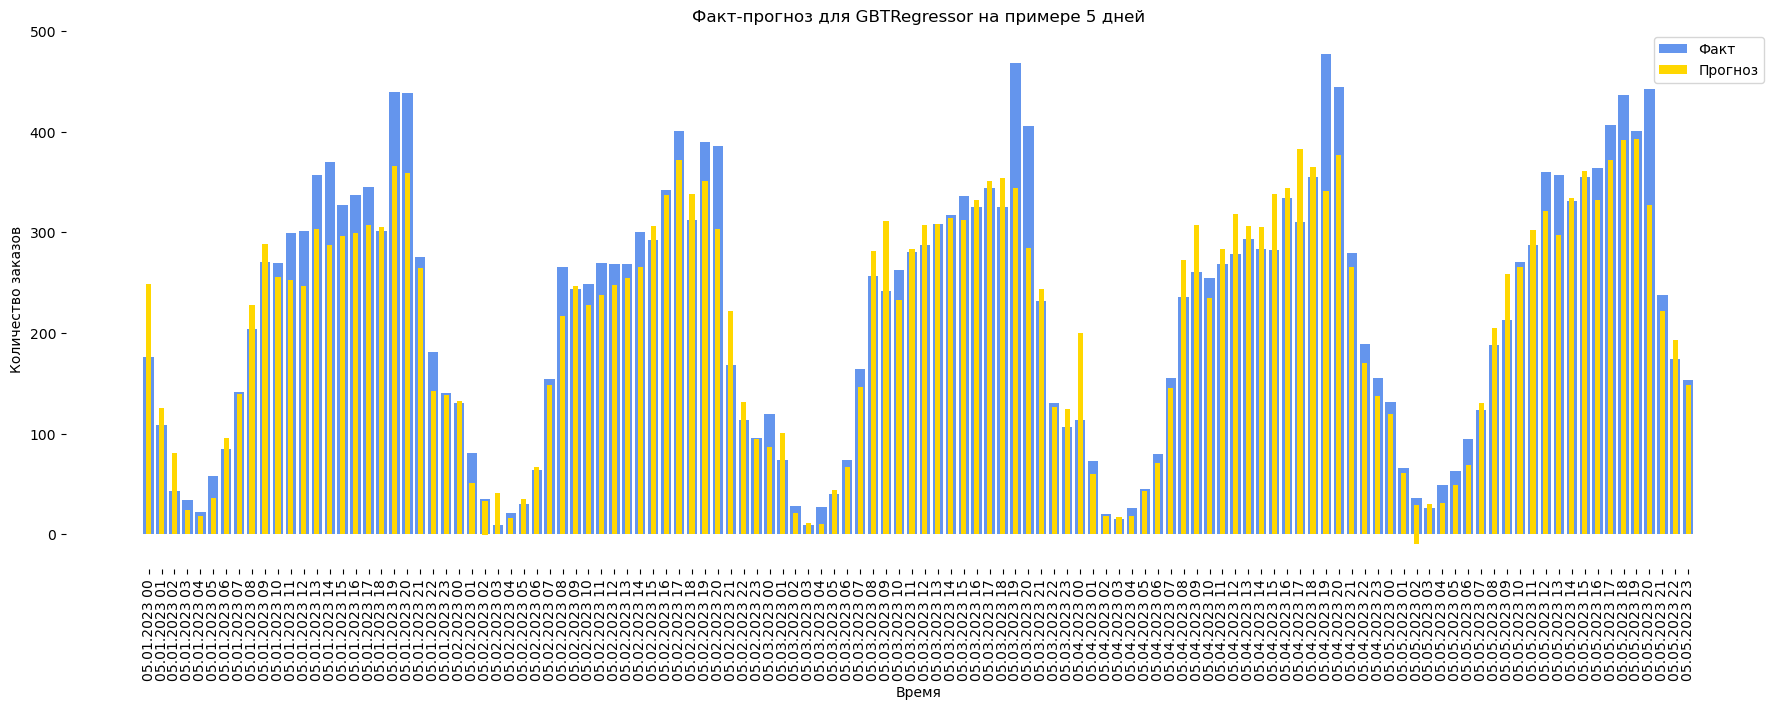

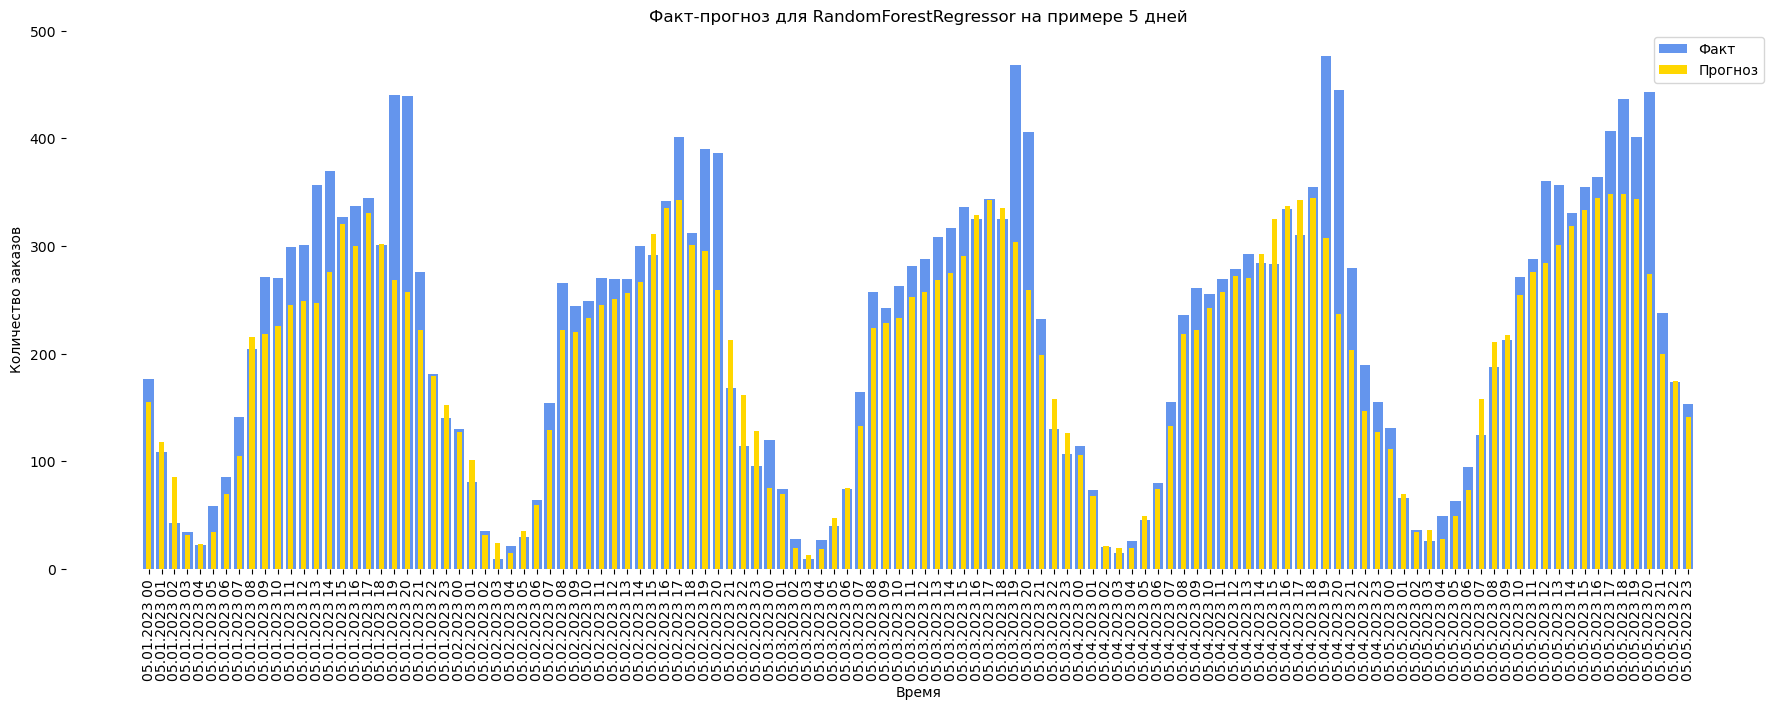

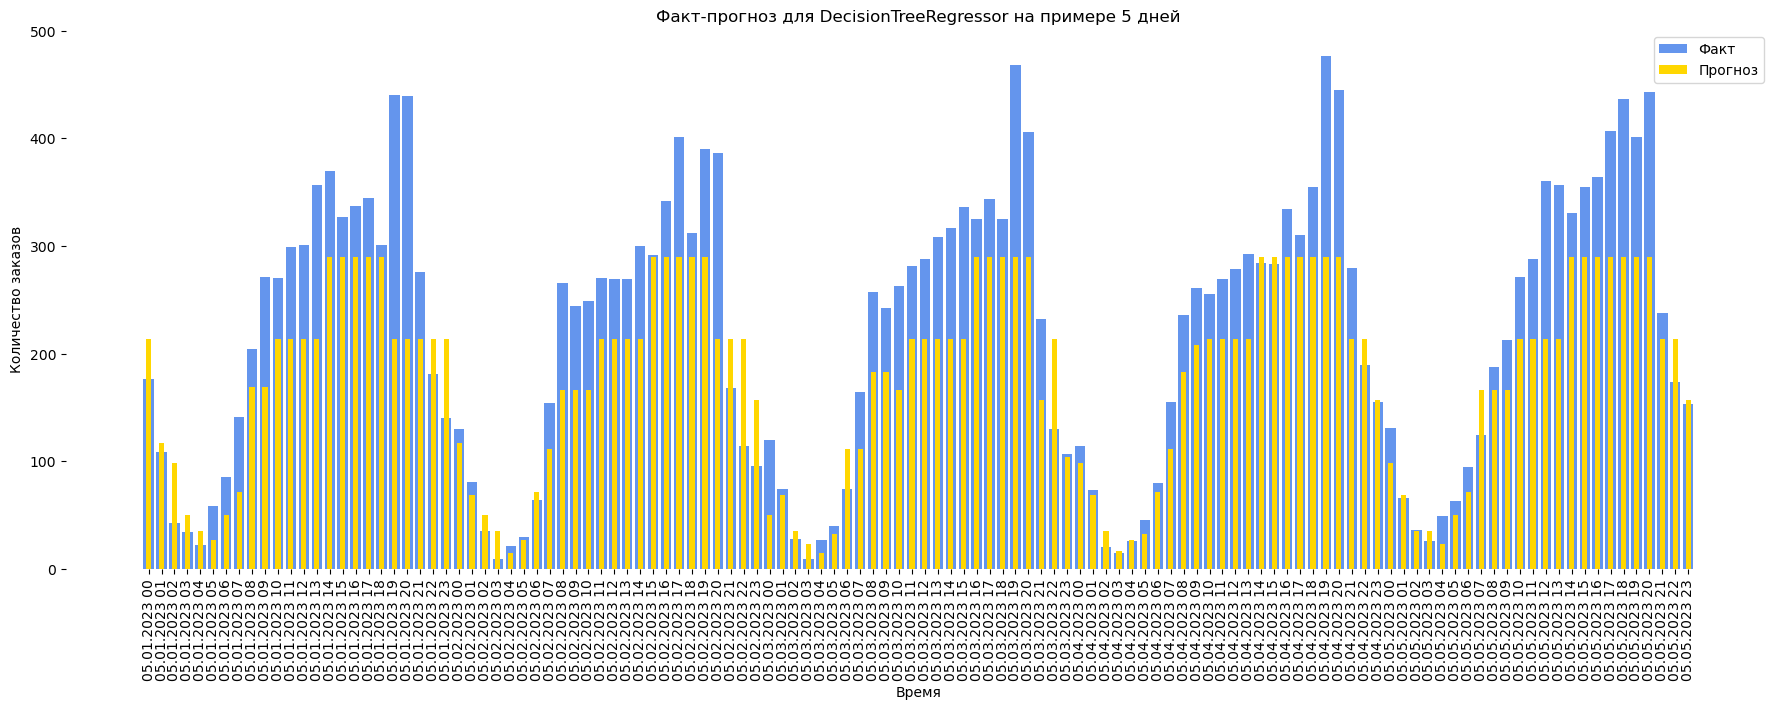

CPU times: user 1min 4s, sys: 1.15 s, total: 1min 5s
Wall time: 8min 7s


,area,model,mae,rmse
0,all,LinearRegressionModel,2.93,8.48
1,all,GBTRegressionModel,2.80,9.84
2,all,RandomForestRegressionModel,2.94,10.81
3,all,DecisionTreeRegressionModel,3.80,14.08


In [ ]:
%%time
for model in models:
    get_result_area(model, data_new, show_res='yes')

pd.DataFrame(list_metrics, columns = ['area', 'model', 'mae', 'rmse', 'trainer_model'])[['area', 'model', 'mae', 'rmse']]

Как видно из данных графика, на базовых настройках наиболее оптимальные результаты показали модели градиентного бустинга и линейной регрессии и случайного леса При этом моделям не удается корректно предсказать количество заказов в пиковую нагрузку.

Мы обучили 4 базовые модели. Посмотрим, какие признаки имеют наибольшую важность для каждой из них.

In [ ]:
def get_feature_importance(i):
    features = [f'Area_{i}' for i in range(len(areas_macro))]+[f'Pickup_Community_Area_{i}' for i in range(len(areas))]+num_cols
    model = list_metrics[i][-1]
    if model.__class__.__name__!='LinearRegressionModel':
        importances = model.featureImportances
    else:
        importances = model.coefficients
    featureImportances = (
                     pd.Series(features, name = 'features')
                       .to_frame().join(pd.Series(list(importances), name = 'importances'))
                       .sort_values('importances',ascending=False).head(15)
                         )
    plt.figure(figsize=(8,4))
    sns.barplot(x ='features',  y='importances', data=featureImportances, palette = 'ch:rot=-.25,hue=1,light=.75')
    plt.xticks(rotation=90)
    plt.title(f'top-15 feature_importance for model {model.__class__.__name__}')
    plt.show()

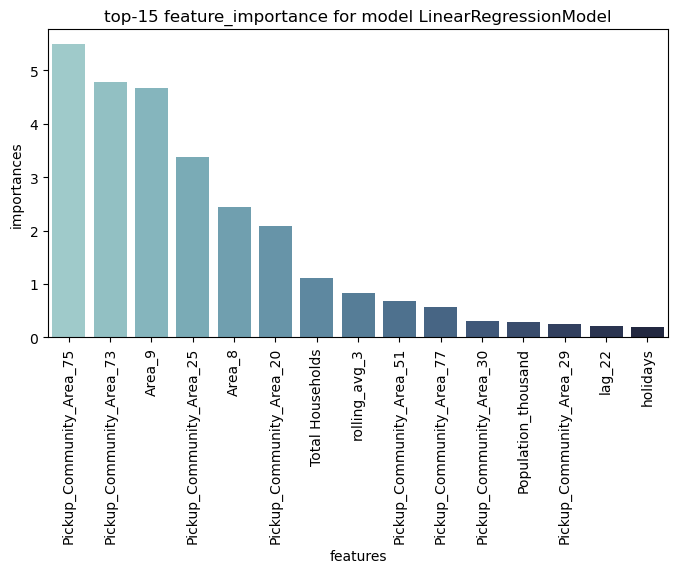

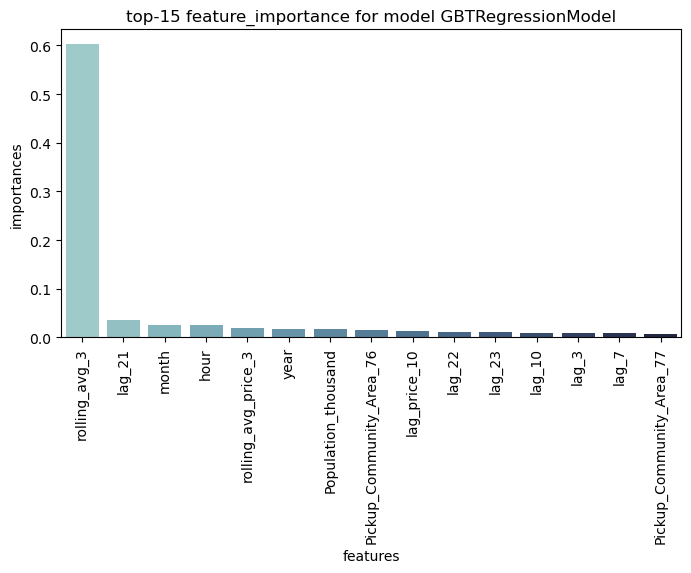

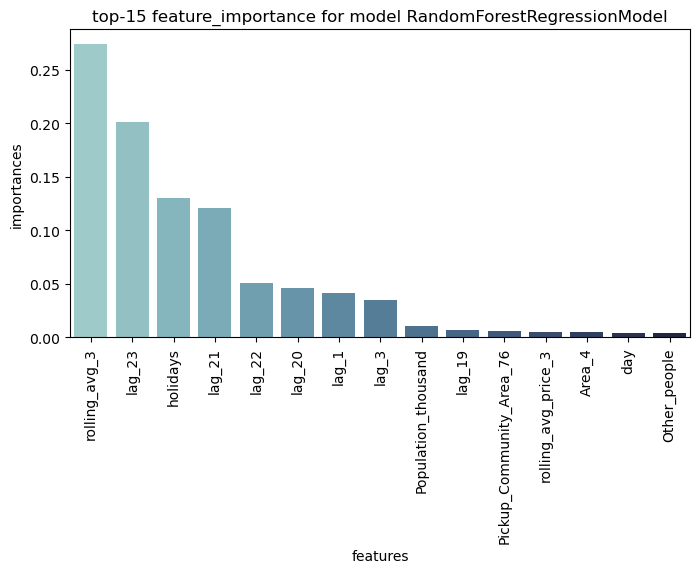

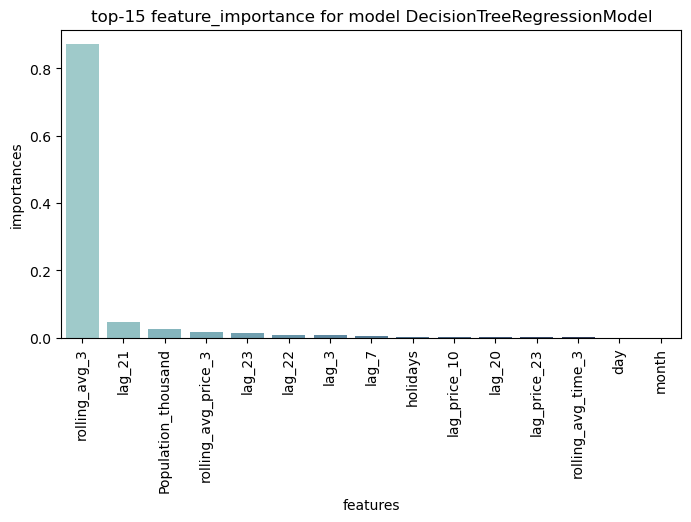

In [ ]:
for i in range(len(models)):
    get_feature_importance(i)

Для линейной регрессии наиболее значимыми признаками оказались:
 - 73, 75, 25, 20, 51 районы, 8 и 9 макрозоны и количество домов в районах
 - Этот набор не кажется очень эффективным с точки средния предсказания. В результате векторизации районов и макрозон мы получили разряженный вектор, и сам факт того что модель выделяет именно раойны в качестве наиболее важных для предсказания, настораживает. Как показали тесты на отдельных районах при использовании линейной регрессии средняя абсолютная ошибка может колебаться от 0 до нескольких тысяч (для районов центральной макрозоны, где заказы такси чаще).

Для бустинга:
 - скользяции среднее от поездок, лаг за 21 час, месяц и час поездки

Для случайоного леса:
 - скользящее среднее от поездок, лаг за 23 часа, праздники, лаги за 20, 21, 1, 3 часа

Для дерева:
 - скользящее среднее от поездок, лаг за 21 час, численность, скользящее среднее от цены поездки

### 3.2. Обучение по районам

In [ ]:
%%time
for area in areas:
    get_result_area(models[1], data_new, area=area)

CPU times: user 2.74 s, sys: 1.13 s, total: 3.87 s
Wall time: 50min 12s


In [ ]:
df = pd.DataFrame(list_metrics, columns = ['area', 'model', 'mae', 'rmse', 'trainer_model'])[['area', 'model', 'mae', 'rmse']]
df = df.loc[df['area'].isin(areas)]

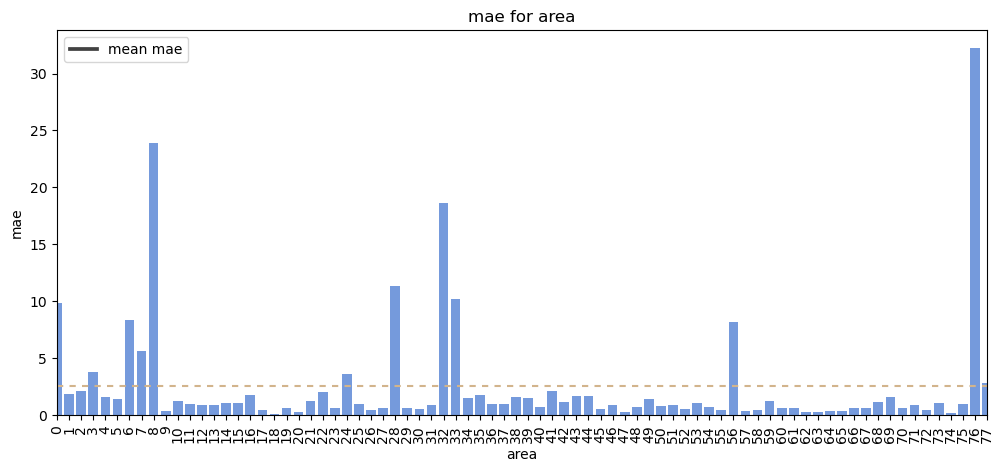

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(df, x ='area',  y='mae', color = 'cornflowerblue')
sns.lineplot(df, x ='area', y=df['mae'].mean(), style=True, dashes=[(3,3)],color = 'tan')
plt.xticks(rotation=90)
plt.legend(['mean mae'])
plt.xlim(0,77)
plt.title(f'mae for area')
plt.show()

In [ ]:
mean = round(df['mae'].mean(), 2)
print(f'Средний mae for areas {mean}')

Средний mae for areas 2.56


### 3.3. Обучение по макрозонам

In [ ]:
%%time
for area in areas_macro:
    get_result_area(models[1], data_new, area=area)

CPU times: user 466 ms, sys: 135 ms, total: 600 ms
Wall time: 9min 28s


In [ ]:
df = pd.DataFrame(list_metrics, columns = ['area', 'model', 'mae', 'rmse', 'trainer_model'])
df = df.loc[df['area'].isin(areas_macro)]

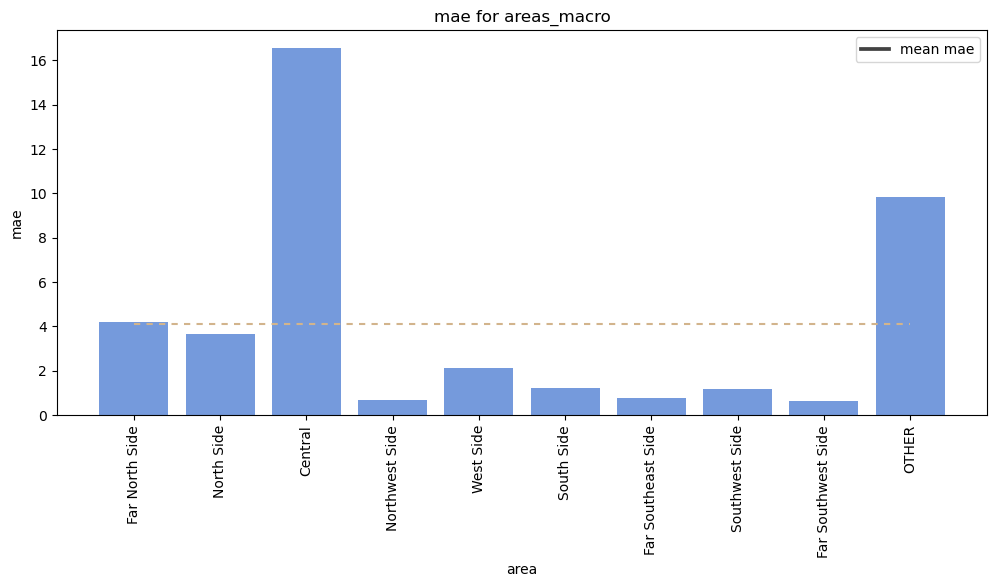

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(df, x ='area',  y='mae', color = 'cornflowerblue')
sns.lineplot(df, x ='area', y=df['mae'].mean(), style=True, dashes=[(3,3)],color = 'tan')
plt.legend(['mean mae'])
plt.xticks(rotation=90)
plt.title(f'mae for areas_macro')
plt.show()

In [ ]:
mean = round(df['mae'].mean(), 2)
print(f'Средний mae for macro_areas {mean}')

Средний mae for macro_areas 4.09


Средний mae на валидации подучился равным 4. Самые неточные предсказания по центру и поездкам за город.

## 4. Тестирование моделей

Протестируем модели первом часе 01.07.2023.

In [ ]:
result = pd.DataFrame(list_metrics, columns = ['area', 'model', 'mae', 'rmse', 'trainer_model'])[['area', 'trainer_model']]

In [ ]:
test_metrics = []

def test_model(df, model, area):
    df = df.filter(F.col('Date_H')=='07.01.2023 00')
    predictions = model.transform(df)
    evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Count_Trip')
    mae = round(evaluator.evaluate(predictions, {evaluator.metricName: 'mae'}), 2)
    rmse = round(evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}), 2)
    test_metrics.append([area, mae, rmse])

Начнем с районов.

In [ ]:
for i, area in enumerate(areas):
    model = result.loc[result['area'] == area]['trainer_model'][i+14]
    _, _, test_data = preprocessing_df(data_new, area=area)
    test_model(test_data, model, area)

In [ ]:
df = pd.DataFrame(test_metrics, columns = ['area', 'mae', 'rmse'])
df.sort_values('mae', ascending=False).head(10)

,area,mae,rmse
0,0,90.85,90.85
76,76,40.45,40.45
28,28,36.55,36.55
6,6,30.55,30.55
24,24,9.80,9.80
22,22,8.35,8.35
56,56,6.13,6.13
32,32,4.57,4.57
4,4,4.24,4.24
8,8,3.86,3.86


Хуже всего модели предсказывают поездки за город и по 76 району. Посмотрим, что там.

 - в 76 районе - аэропорт. Возможно здесь было бы полезно получить информацию о пассажиропотоке в за исследуемый период. Примечательно то, что по 32 региону, где находится второй аэропорт Чикаго, прогнозы точнее.
 - в 28 районе NEAR WEST SIDE много университетов и развлекательных заведений. Здесь в качестве признаков можно добавить данные об количестве университетов и учащихся в них
 - 6 район Lakeview - пожалуй, можно назвать самым молодежным и тусовочным районом Чикаго. Здесь проходят большинство фестивалей и парадов.
В 6 районе можно воспользоваться данными о мероприятиях (есть/нет), опубликованных в афишах.

In [ ]:
mean = round(df['mae'].mean(), 2)
print(f'Средний mae for areas {mean}')

Средний mae for areas 3.45


Попробуем предсказать в разрезе макрозон.

In [ ]:
for i, area in enumerate(areas_macro):
    model = result.loc[result['area'] == area]['trainer_model'][i+4]
    _, _, test_data = preprocessing_df(data_new, area=area)
    test_model(test_data, model, area)

In [ ]:
df = pd.DataFrame(test_metrics, columns = ['area', 'mae', 'rmse'])
df = df.loc[df['area'].isin(areas_macro)]
df

,area,mae,rmse
78,Far North Side,1.55,2.45
79,North Side,5.06,8.35
80,Central,11.85,17.19
81,Northwest Side,0.47,0.88
82,West Side,3.18,7.47
83,South Side,0.61,0.90
84,Far Southeast Side,0.37,0.54
85,Southwest Side,0.66,1.80
86,Far Southwest Side,0.08,0.10
87,OTHER,90.85,90.85


В целом результаты приемлемые, за исключением центрального района и поездок за город. Здесь модель предсказывает плохо.

In [ ]:
mean = round(df['mae'].mean(), 2)
print(f'Средний mae for macro_areas {mean}')

Средний mae for macro_areas 11.47


Если исключить загородные поездки, средний mae составит 2,64.

Проверим на этом же временном отрезке и модель, обученную на полной выборке, без разбиения на районы и округа.

In [ ]:
model = list_metrics[1][-1]
_, _, test_data = preprocessing_df(data_new)
test_model(test_data, model, 'all')

pd.DataFrame(test_metrics[-1]).T.rename(columns = {0: 'area', 1: 'mae', 2: 'rmse'})

,area,mae,rmse
0,all,3.17,10.4


Увы, в этом случае результаты оказались чуть хуже.

## 5. Вывод

Цель проекта: Построить ML модель на Spark предсказания количества заказов на следующий час для каждого района
В рамках этого было проведено исследование имеющихся данных, подготовлен набор признаков для обучения и обучены модели.

Сначала рассмотрим общие наблюдения:

 - Большее количество заказов наблюдается в Central, Far North Side, West Side. При это дальность поездки больше из округа Far North Side  - это один из самых удаленных от центра округов.
 - Основные пункты назначения - центральная часть города и 2 аэропорта (Охара и Мидвэй).
 - В рабочее время утром преобладает заказ такси из West Side (предположительно из спального района в центр). А в течение рабочего дня и ночью - Central, Far North Side. Вспомним, именно в этих районах находятся аэропорты.
 - Основные часы-пик для таксистов - с 17-21 часа
 - Ночью дальность поездок увеличивается
 - В январе, июле, декабре дальность поездок увеличивается. Возможно это связано с праздниками.
 - Стоимость поездки возрастает в ночные часы и в воскресение.
 - Явной зависимости между числом заказов и погодными условиями не выявлено.


На основании проведенного анализа было принято решение попробовать обучить модели по следующим срезам:
 - по всей выборке
 - по районам
 - по макрозонам

В качестве базовых моделей на всей выборке были протестированы:
 - LinearRegression
 - GBTRegressor
 - RandomForestRegressor
 - DecisionTreeRegres

Наиболее оптимальные результаты показали модели градиентного бустинга и линейной регрессии и случайного леса. При этом моделям не удается корректно предсказать количество заказов в пиковую нагрузку.or


Для линейной регрессии наиболее значимыми признаками оказались:
 - 73, 75, 25, 20, 51 районы, 8 и 9 макрозоны и количество домов в районах
 - Этот набор не кажется очень эффективным с точки средния предсказания. В результате векторизации районов и макрозон мы получили разряженный вектор, и сам факт того что модель выделяет именно раойны в качестве наиболее важных для предсказания, настораживает. Как показали тесты на отдельных районах при использовании линейной регрессии средняя абсолютная ошибка может колебаться от 0 до нескольких тысяч (для районов центральной макрозоны, где заказы такси чаще).

Для бустинга:
 - скользяции среднее от поездок, лаг за 21 час, месяц и час поездки

Для случайоного леса:
 - скользящее среднее от поездок, лаг за 23 часа, праздники, лаги за 20, 21, 1, 3 часа

Для дерева:
 - скользящее среднее от поездок, лаг за 21 час, численность, скользящее среднее от цены поездки

В рамках тестирования наилучше всего себя показали модели обученные по макрозонам. Если убрать аномальное большое mae по междугородним поездкам, то средняя абсолютная ошибка составит 2,64. По всей выборке mae составил 3,17. По районам - 3,45.

Хуже всего модели предсказывают поездки за город и по 76 району. Посмотрим, что там.
 - в 76 районе - аэропорт. Возможно здесь было бы полезно получить информацию о пассажиропотоке в за исследуемый период. Примечательно то, что по 32 региону, где находится второй аэропорт Чикаго, прогнозы точнее.
 - в 28 районе NEAR WEST SIDE много университетов и развлекательных заведений. Здесь в качестве признаков можно добавить данные об количестве университетов и учащихся в них
 - 6 район Lakeview - пожалуй, можно назвать самым молодежным и тусовочным районом Чикаго. Здесь проходят большинство фестивалей и парадов. В 6 районе можно воспользоваться данными о мероприятиях (есть/нет), опубликованных в афишах.

Возможностей улучшения проекта может быть очень много. Здесь мы испробовали т олько самые очевидные.
 - использовать незадействованные признаки (например, идентификатор такси, таксопарки)
 - по имеющимся координатам раздробить на более мелкие районы
 - изучить более подробно тренды, сезонность, цикличность
 - использовать данные о пассажиропотоках и другую общедоступную информацию
 - попробовать ARIMA
 - подобрать признаки и гиперпараметры для моделей
 - и т.д...